## Data import and cleaning

In [1]:
#basic library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import pickle

In [2]:
#Install yfinance and import Data
import yfinance as yf
from yfinance import Ticker
import functions

In [3]:
# set parameters for yfinance data

tickers = ['^GSPC','^DJI','^IXIC','^NDX','AAPL', 'GOOGL', 'MSFT', 'IBM', 'NVDA','META']
start_date = '01 01 2013'
end_date = '31 12 2023'

selected_variable = 'Close'

# call function to get data
stock_dict = functions.get_stock_data(tickers, start_date, end_date, selected_variable)

In [4]:
# check index type
type(stock_dict['AAPL'].index)


pandas.core.indexes.datetimes.DatetimeIndex

In [5]:
# check series name
print(stock_dict['IBM'].name)

Close


### Raw Data

In [6]:
# saving raw data csv files
dir_path = '../data/'
prefix = 'raw'
functions.save_series_csv(stock_dict, dir_path, prefix)

## data cleanup

### format date (index)

In [7]:
formatted_dict = functions.remove_index_timezone(stock_dict)

### Missing dates

how to handle missing values?
as the stock market is closed on weekends, the values will be carried forward from the previous Friday's close price/

other options:
 
 Rolling Statistics Imputation: This method substitutes missing values with a rolling statistic (like mean, median, or mode) over a specified window period. This method can handle non-random missingness and preserve temporal dependence, but the choice of window size and statistic can significantly affect the results 1.
 
 Using pandas for rolling statistics imputation
 
window_size = 5 # adjust this value according to your needs

df_imputed = df.rolling(window_size).mean().fillna(df)

Interpolation: This method estimates missing values based on the surrounding values. Linear interpolation is suitable for linear trends, while polynomial interpolation can capture more complex trends. However, these methods can distort the data if the trend is not linear or if there's a seasonal component.

Using pandas for linear interpolation
df_imputed = df.interpolate()


In [8]:
resampled_data = functions.resample_data(formatted_dict)

In [9]:
ffilled_data = functions.ffill_data(resampled_data)

In [10]:
data = ffilled_data

### Clean Data

In [11]:
# saving cleaned data csv files
dir_path = '../data/'
prefix = 'cleaned'
functions.save_series_csv(ffilled_data, dir_path, prefix)

## Initial visualization

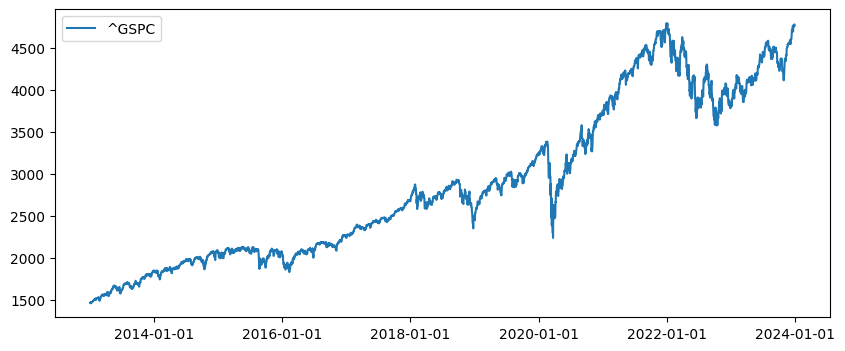

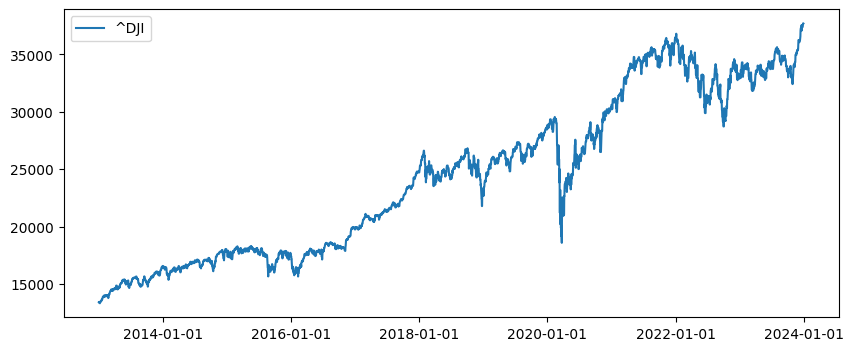

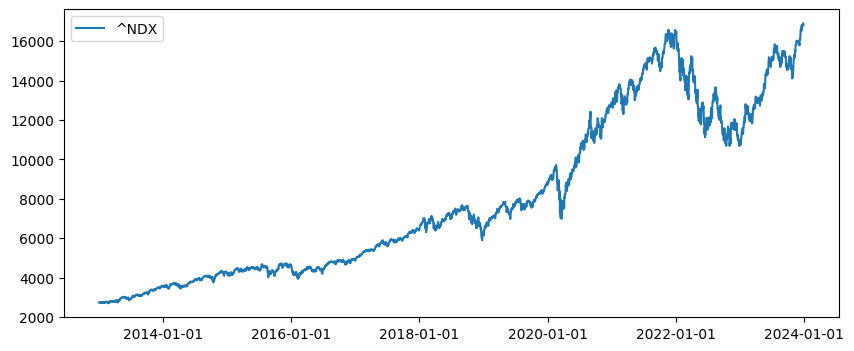

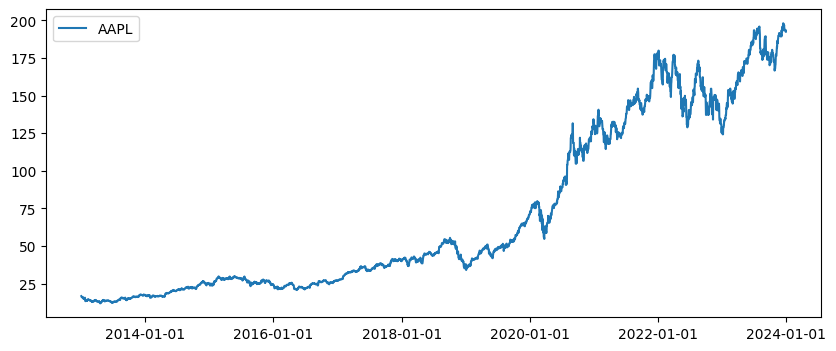

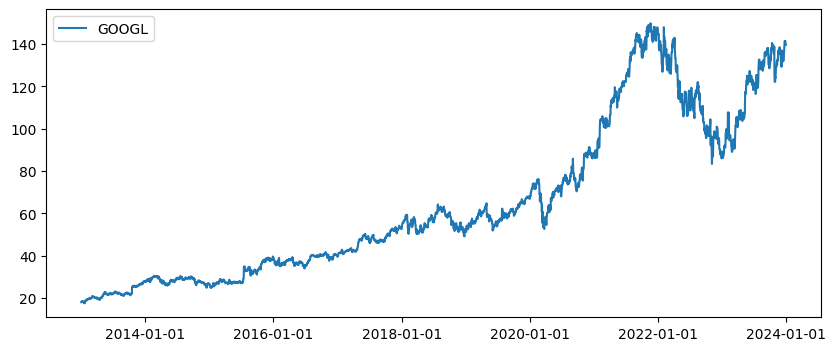

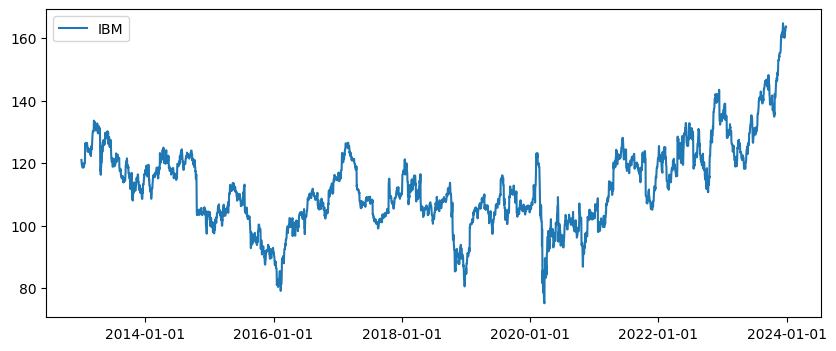

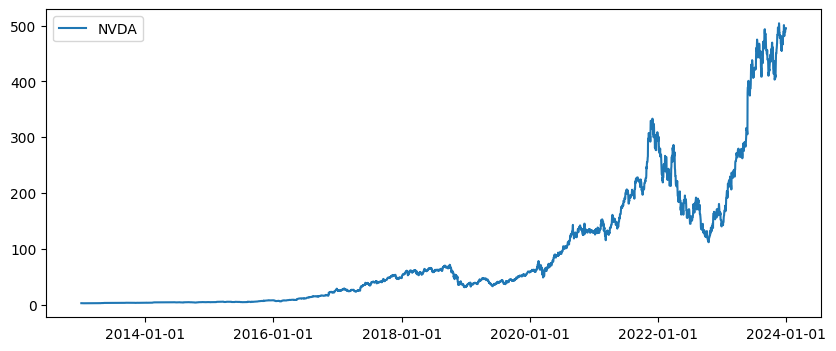

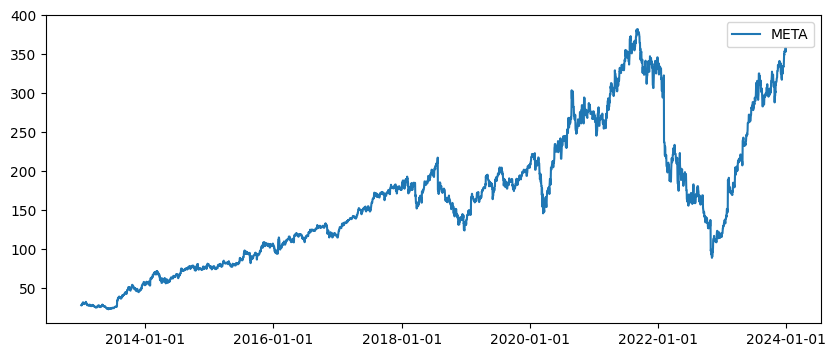

In [12]:
functions.plot_time_series(data)

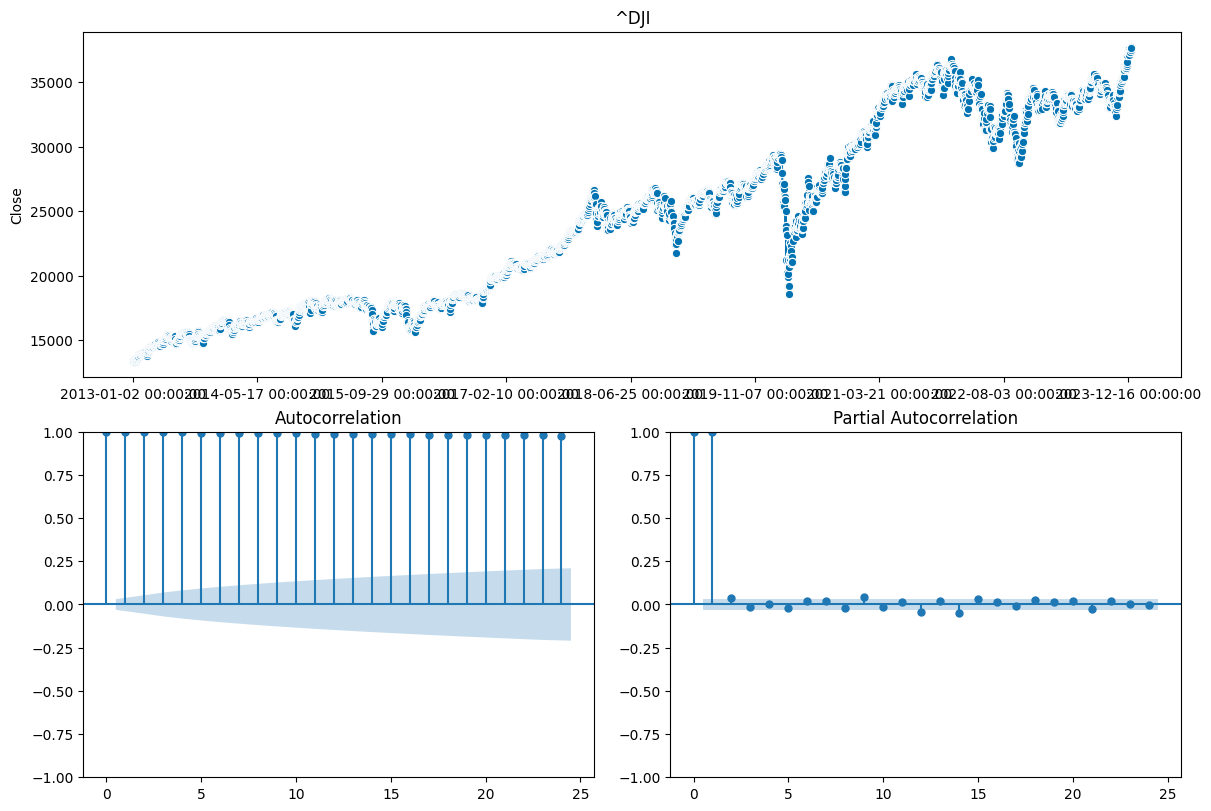

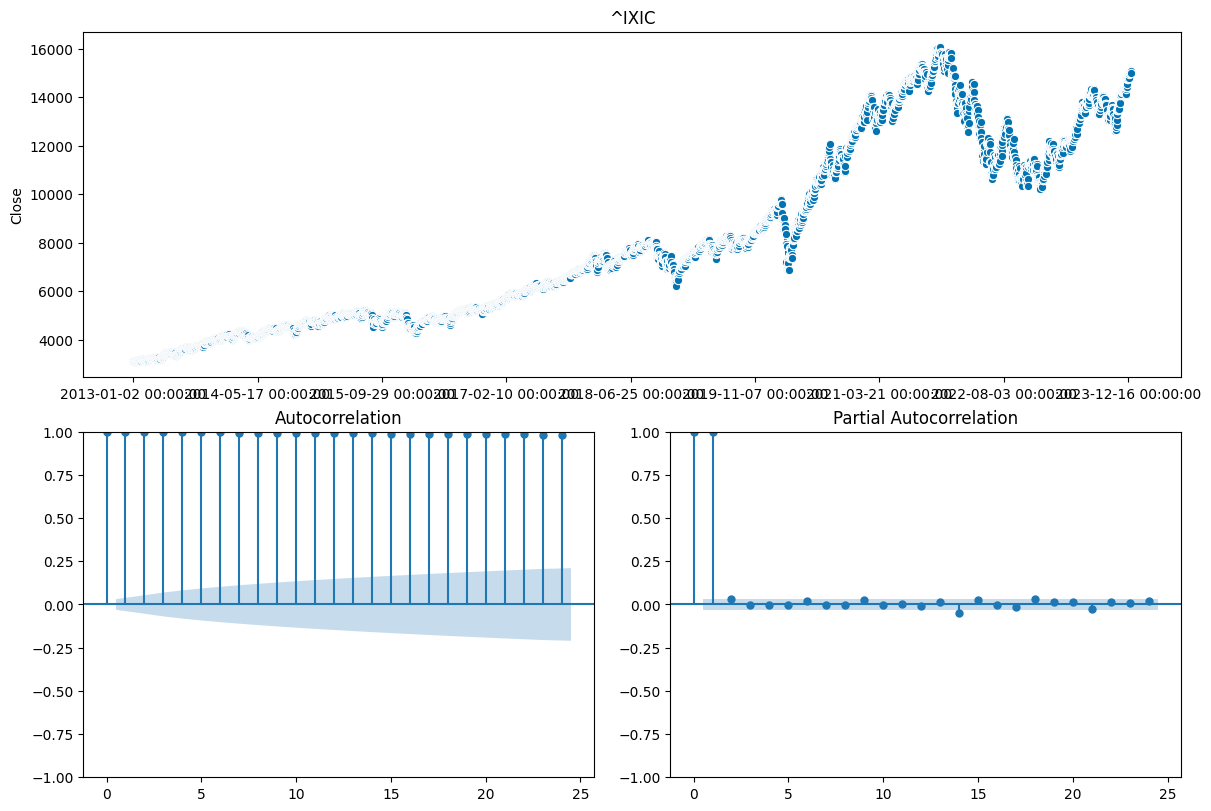

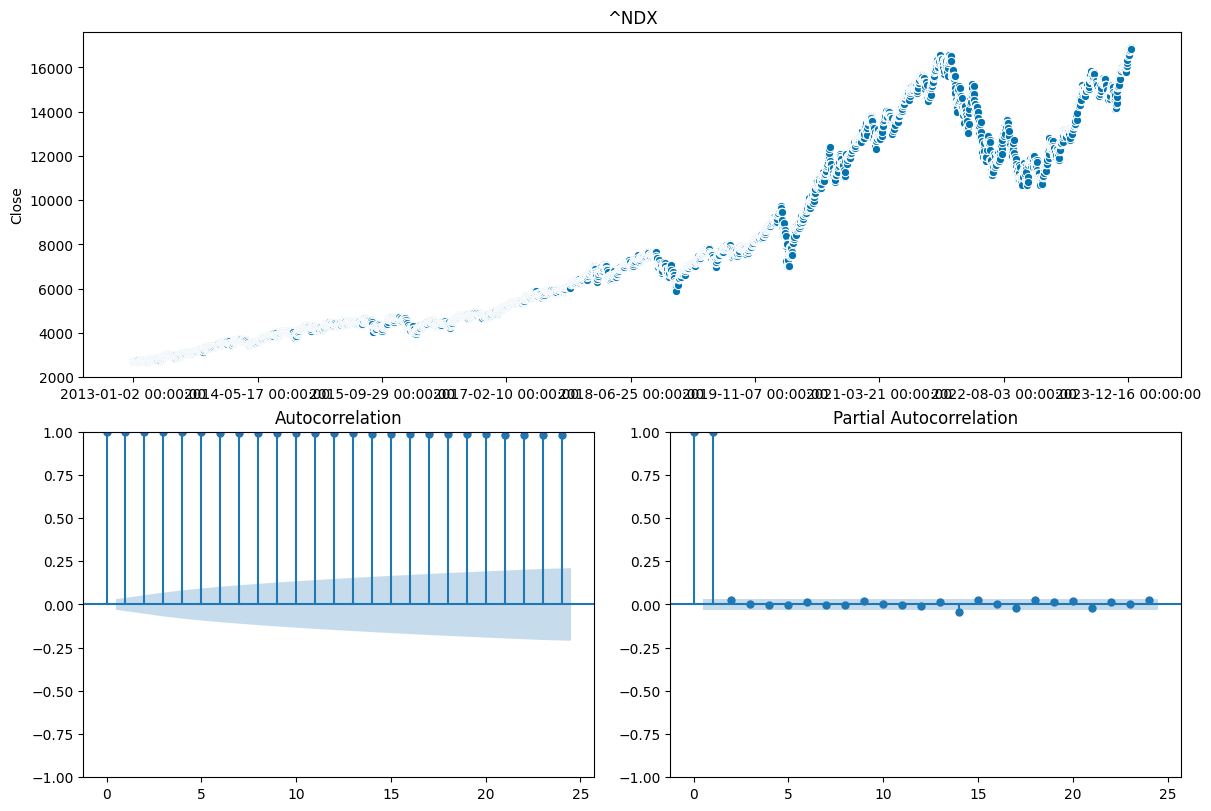

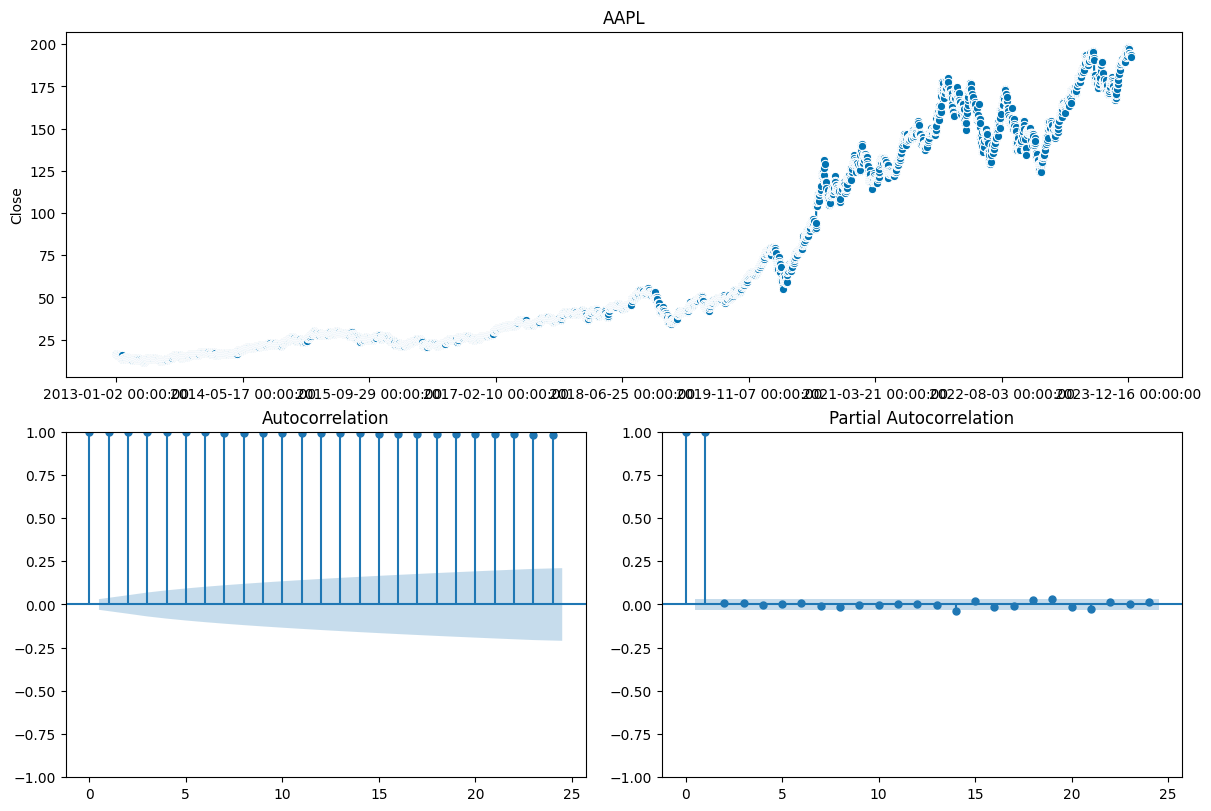

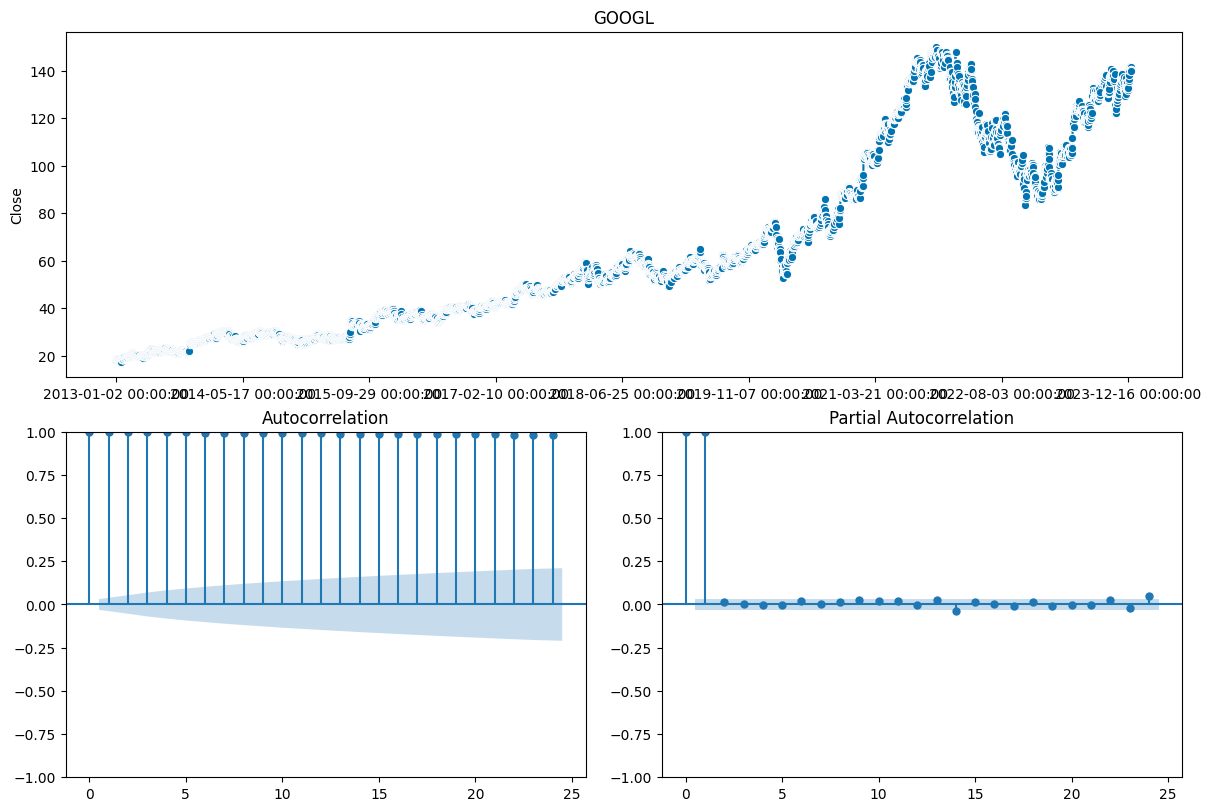

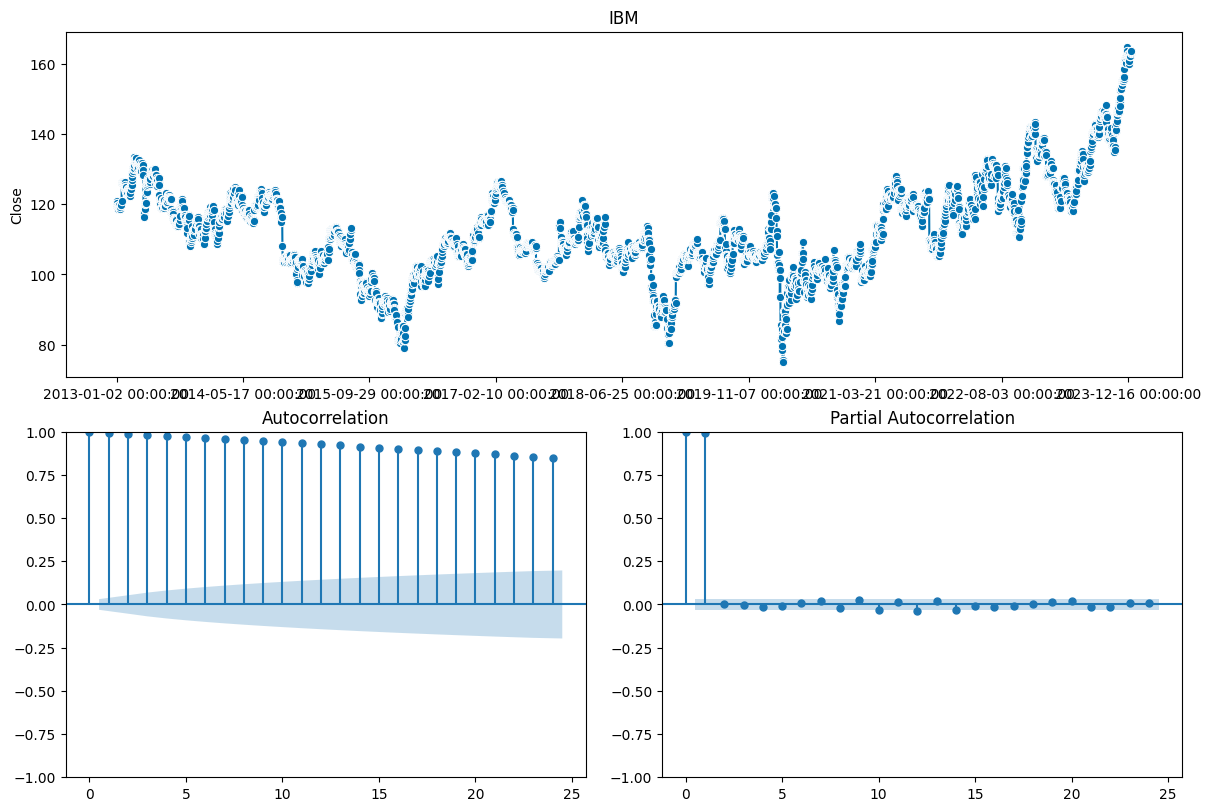

In [13]:
functions.plot_time_series_corr(data)

In [14]:
# data exploration: trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

seasonal_decompose_result = seasonal_decompose(data['IBM'])
seasonal_decompose_result.plot()
plt.title(f'Seasonal Decomposition')
plt.show()

## time range selection

In [15]:
# creating dataframe to be used throughout the next section of the workbook for modelling and forecasting? 
data_ibm_all = data['IBM']

In [16]:
# set time frequency
print(data_ibm_all.index.freq)
data_ibm_all.index.freq = 'D' # Set the frequency to daily
print(data_ibm_all.index.freq)

None
<Day>


## Hypothesis testing: stationary data

We will observe and test the data to discover if it's stationary or not by:  
a) visual tests  
b) summary statistics by partition  
c) statistical tests  
    -- Dickey-Fuller (DF) test   
    -- Kwiatkowski-Phillips-Schmidt-Shin (KPSS)  

### Dickey-Fuller Test

Dickey-Fuller Test
The Dickey-Fuller (DF) test was developed and popularized by Dickey and Fuller (1979). The null hypothesis of DF test is that there is a unit root in an AR model, which implies that the data series is not stationary. The alternative hypothesis is generally stationarity or trend stationarity but can be different depending on the version of the test is being used.

Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

parameters:  
“c” : constant only (default).
“ct” : constant and trend.
“ctt” : constant, and linear and quadratic trend.
“n” : no constant, no trend.


In [17]:
adf_panel_results = functions.adf_test(data)

In [18]:
adf_panel_results

ticker  ADF Statistic   p-value  used_lag  nobs  Critical Value 1%  \
0  ^GSPC      -0.345935  0.918742        20  3993          -3.431989   
1   ^DJI      -0.624802  0.865279        23  3990          -3.431990   
2  ^IXIC      -0.323742  0.922074        20  3993          -3.431989   
3   ^NDX       0.198602  0.972183        20  3993          -3.431989   
4   AAPL       0.503554  0.984981        26  3987          -3.431991   
5  GOOGL       0.157475  0.969773        31  3982          -3.431993   
6   MSFT       1.247725  0.996300        27  3986          -3.431992   
7    IBM      -2.079514  0.252831        13  4000          -3.431986   
8   NVDA       2.136038  0.998826        31  3982          -3.431993   
9   META      -0.703375  0.845873        16  3997          -3.431987   

   Critical Value 5%  Critical Value 10%  
0          -2.862264           -2.567155  
1          -2.862265           -2.567156  
2          -2.862264           -2.567155  
3          -2.862264           -2.567155  
4          -2.862265           -2.567156  
5          -2.862266           -2.567157  
6          -2.862265           -2.567156  
7          -2.862263           -2.567155  
8          -2.862266           -2.567157  
9          -2.862263           -2.567155

Null - hypothesis:  
No reason found to reject the null hypothesis found as the p-value is greater than the significance level  
therefore this test assumes the data is non-stationary

### KPSS test

The KPSS test, short for, Kwiatkowski-Phillips-Schmidt-Shin (KPSS), is a type of Unit root test that tests for the stationarity of a given series around a deterministic trend. In other words, the test is somewhat similar in spirit to the ADF test. A common misconception, however, is that it can be used interchangeably with the ADF test. This can lead to misinterpretations about stationarity, which can easily go undetected, causing more problems down the line.  
source: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=That%20is%2C%20if%20the%20p%2Dvalue%20is%20%3C%20significance%20level,the%20tested%20series%20is%20stationary.

In [19]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series_dict: dict) -> pd.DataFrame:
    """
    performs kpss test on each series in the dictionary
    input: series_dict - dictionary with keys as identifiers and values as pandas series
    output: pd.DataFrame - dataframe containing the results of the kpss tests
    """
    results = []
    for ticker, series in series_dict.items():
        kpss_result = kpss(
            series,
            regression='c', 
            nlags='auto', 
            store=True)

        result = {
            'ticker': ticker,
            'KPSS Statistic': kpss_result[0],
            'p-value': kpss_result[1],
            'used_lag': kpss_result[2]
        }

        results.append(result)

    return pd.DataFrame(results)

In [20]:
kpss_panel_results = functions.kpss_test(data)
kpss_panel_results

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/stock_price_prediction/notebooks/functions.py:227: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/stock_price_prediction/notebooks/functions.py:227: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/stock_price_prediction/notebooks/functions.py:227: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/stock_price_prediction/notebooks/functions.py:227: Inter

ticker  KPSS Statistic  p-value  \
0  ^GSPC        9.489351     0.01   
1   ^DJI        9.717518     0.01   
2  ^IXIC        9.213111     0.01   
3   ^NDX        9.298403     0.01   
4   AAPL        8.931876     0.01   
5  GOOGL        8.889316     0.01   
6   MSFT        9.323887     0.01   
7    IBM        2.108312     0.01   
8   NVDA        7.062088     0.01   
9   META        7.473362     0.01   

                                            used_lag  
0  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
1  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
2  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
3  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
4  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
5  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
6  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
7  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
8  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
9  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...

### autocorrelation (non-stationary data)

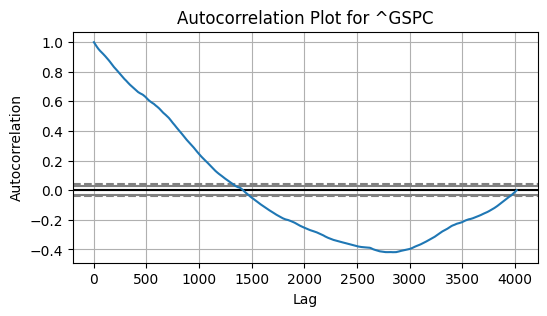

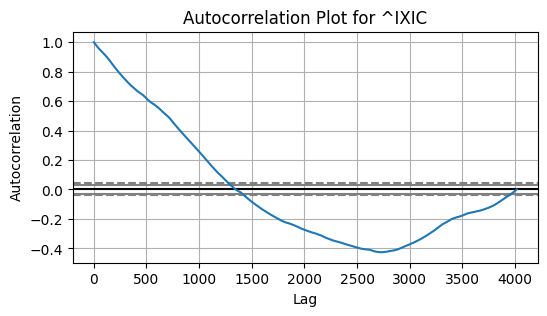

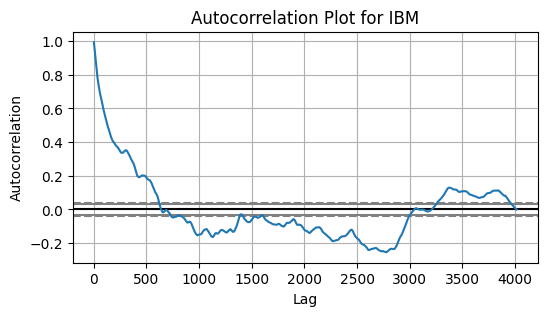

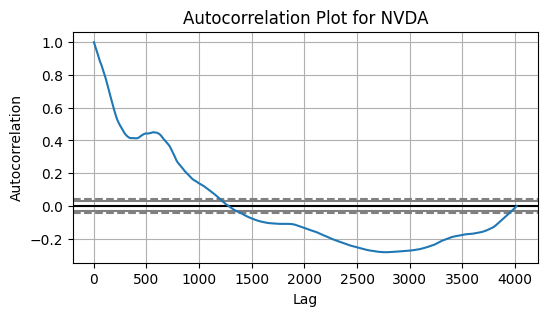

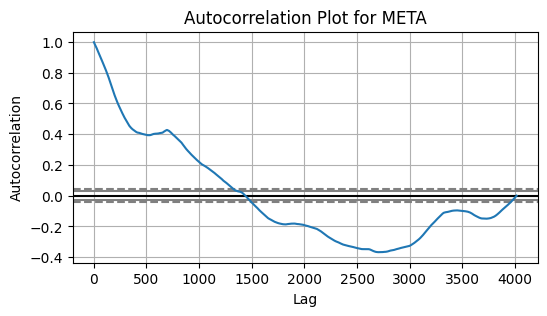

In [21]:
functions.autocorr_plots(data)

Plotting ACF for ^GSPC


Plotting ACF for ^DJI


Plotting ACF for ^IXIC


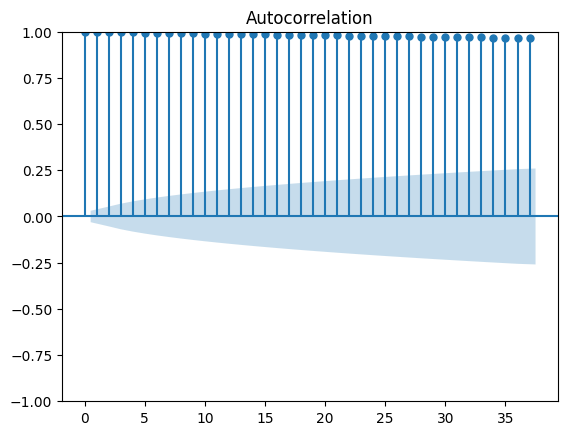

Plotting ACF for ^NDX


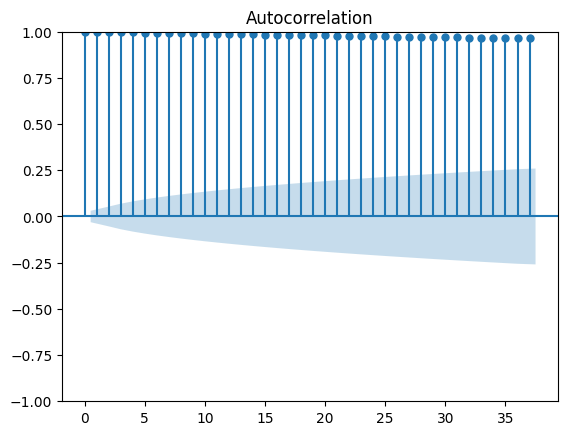

Plotting ACF for AAPL


Plotting ACF for GOOGL


Plotting ACF for MSFT


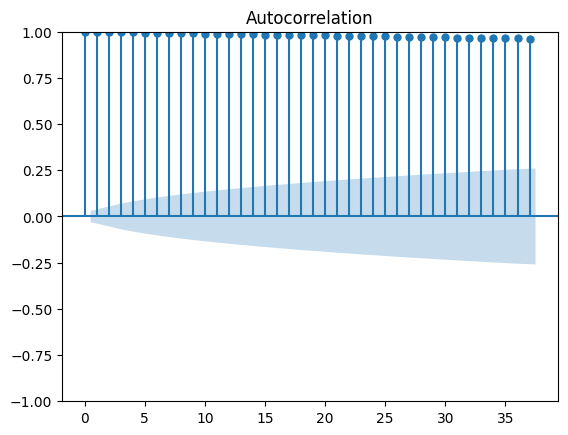

Plotting ACF for IBM


Plotting ACF for NVDA


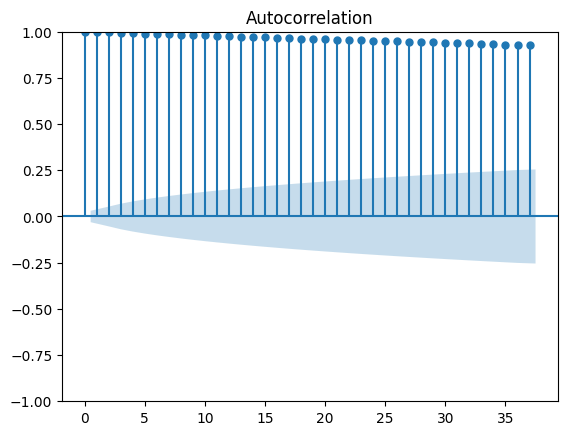

Plotting ACF for META


In [22]:
functions.plot_acfs(data)

Plotting PACF for ^GSPC


Plotting PACF for ^DJI


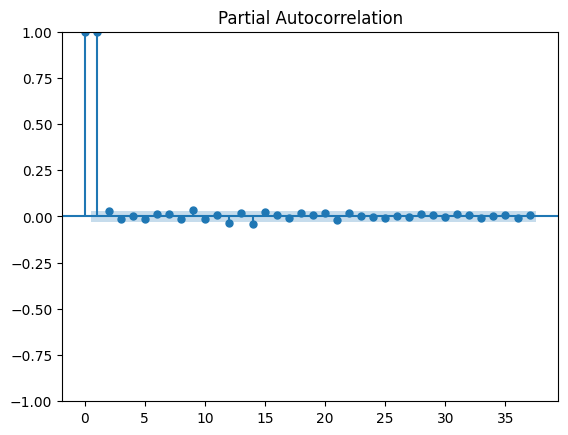

Plotting PACF for ^IXIC


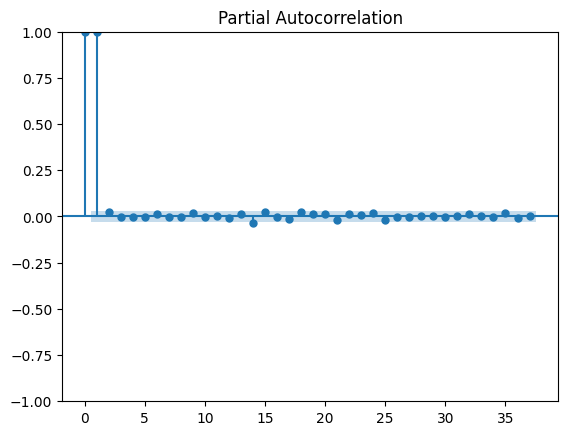

Plotting PACF for ^NDX


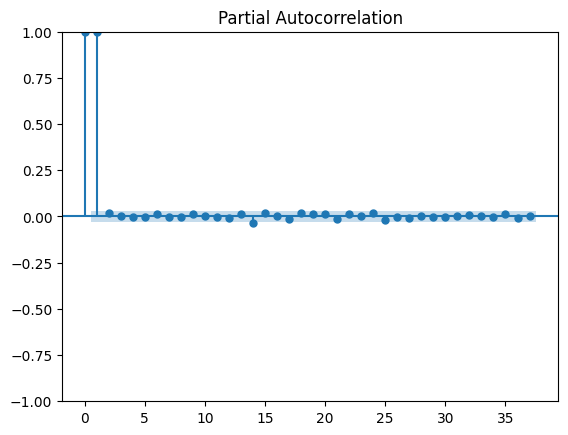

Plotting PACF for AAPL


Plotting PACF for GOOGL


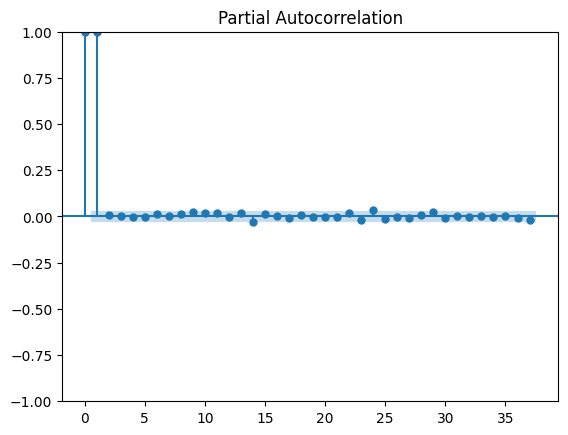

Plotting PACF for MSFT


Plotting PACF for IBM


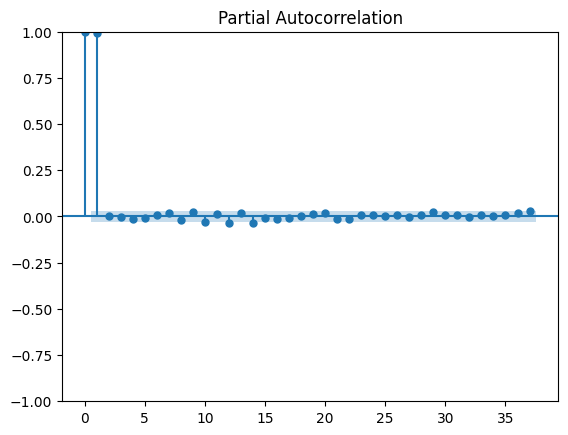

Plotting PACF for NVDA


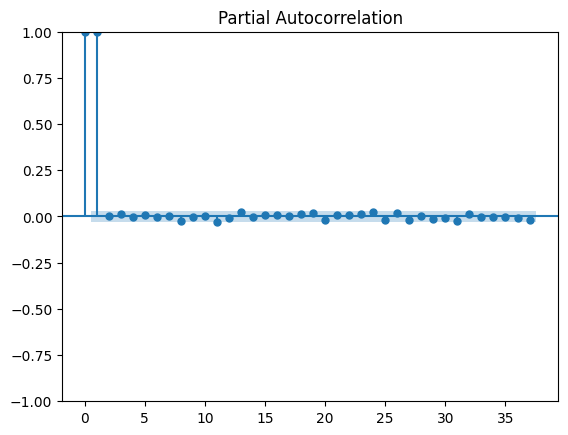

Plotting PACF for META


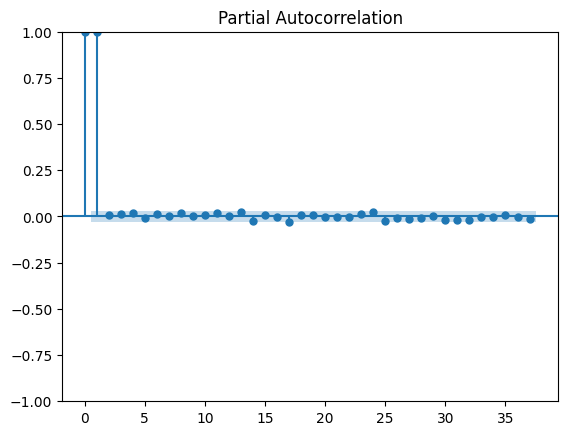

In [23]:
functions.plot_pacfs(data)

## Train / Test Split --> Start "data" for testing

### temporal split

In [24]:
data_ibm_all.index.freq, #y_transformed.index.freq,

(<Day>,)

In [25]:
data_ibm_all.index.freq = 'D' # Set the frequency to daily

In [26]:
data_ibm_all.shape

(4014,)

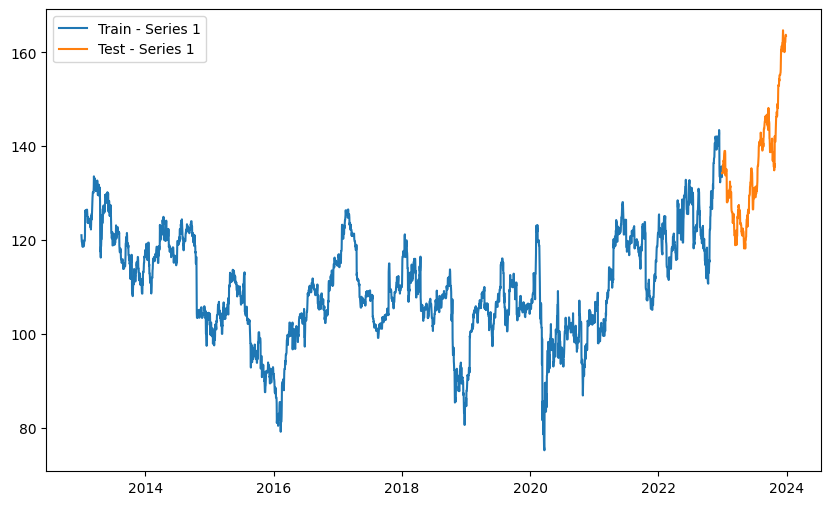

(2022-12-27    135.681366
 2022-12-28    133.394928
 2022-12-29    134.385712
 Freq: D, Name: Close, dtype: float64,
 2022-12-30    134.223755
 2022-12-31    134.223755
 2023-01-01    134.223755
 Freq: D, Name: Close, dtype: float64)

In [27]:
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split

#y_train, y_test = temporal_train_test_split(y_transformed, test_size=90)
y_train, y_test = temporal_train_test_split(data_ibm_all, test_size=365)

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')

plt.legend()
plt.show()

y_train.tail(3), y_test.head(3)

In [28]:
y_train.index.freq, y_test.index.freq,

(<Day>, <Day>)

## Converting non - stationary data to stationary. 
differencing, log transformation, or a Box-Cox transformation. 

Statistical stationarity: A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past!   (Recall our famous forecasting quotes.)  The predictions for the stationarized series can then be "untransformed," by reversing whatever mathematical transformations were previously used, to obtain predictions for the original series. (The details are normally taken care of by your software.) Thus, finding the sequence of transformations needed to stationarize a time series often provides important clues in the search for an appropriate forecasting model.  Stationarizing a time series through differencing (where needed) is an important part of the process of fitting an ARIMA model, as discussed in the ARIMA pages of these notes.

Another reason for trying to stationarize a time series is to be able to obtain meaningful sample statistics such as means, variances, and correlations with other variables. Such statistics are useful as descriptors of future behavior only if the series is stationary. For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables. For this reason you should be cautious about trying to extrapolate regression models fitted to nonstationary data.

Most business and economic time series are far from stationary when expressed in their original units of measurement, and even after deflation or seasonal adjustment they will typically still exhibit trends, cycles, random-walking, and other non-stationary behavior.   If the series has a stable long-run trend and tends to revert to the trend line following a disturbance, it may be possible to stationarize it by de-trending (e.g., by fitting a trend line and subtracting it out prior to fitting a model, or else by including the time index as an independent variable in a regression or ARIMA model), perhaps in conjunction with logging or deflating.   Such a series is said to be trend-stationary.    However, sometimes even de-trending is not sufficient to make the series stationary, in which case it may be necessary to transform it into a series of period-to-period and/or season-to-season differences.  If the mean, variance, and autocorrelations of the original series are not constant in time, even after detrending, perhaps the statistics of the changes in the series between periods or between seasons will be constant.   Such a series is said to be difference-stationary.  (Sometimes it can be hard to tell the difference between a series that is trend-stationary and one that is difference-stationary, and a so-called unit root test may be used to get a more definitive answer.  We will return to this topic later in the course.)
(Return to top of page.)
source: https://people.duke.edu/~rnau/411diff.htm

In [29]:
from sktime.transformations.series.difference import Differencer

# Initialize the differencer
differencer = Differencer(lags=1, na_handling='fill_zero', memory='all') # Adjust the lags according to your needs

# Fit the differencer on the training data
differencer.fit(y_train)

# Transform the training data
train_transformed = differencer.transform(y_train)

### transformation checks

In [30]:
# set time frequency
print(train_transformed.index.freq)
train_transformed.index.freq = 'D' # Set the frequency to daily
print(train_transformed.index.freq)

<Day>
<Day>


In [31]:
data_ibm_all.index.freq, y_train.index.freq, train_transformed.index.freq

(<Day>, <Day>, <Day>)

In [32]:
# checks
y_train.head(5), train_transformed.head(5)

(2013-01-02    121.021309
 2013-01-03    120.355652
 2013-01-04    119.566734
 2013-01-05    119.566734
 2013-01-06    119.566734
 Freq: D, Name: Close, dtype: float64,
 2013-01-02    0.000000
 2013-01-03   -0.665657
 2013-01-04   -0.788918
 2013-01-05    0.000000
 2013-01-06    0.000000
 Freq: D, Name: Close, dtype: float64)

In [33]:
# checks
y_train.tail(5), train_transformed.tail(5)

(2022-12-25    134.947800
 2022-12-26    134.947800
 2022-12-27    135.681366
 2022-12-28    133.394928
 2022-12-29    134.385712
 Freq: D, Name: Close, dtype: float64,
 2022-12-25    0.000000
 2022-12-26    0.000000
 2022-12-27    0.733566
 2022-12-28   -2.286438
 2022-12-29    0.990784
 Freq: D, Name: Close, dtype: float64)

In [34]:
# checks
train_transformed.describe()

count    3649.000000
mean        0.003662
std         1.300532
min       -12.025108
25%        -0.334717
50%         0.000000
75%         0.433075
max         9.217438
Name: Close, dtype: float64

In [35]:
# create difctionary to use previous function:
train_transformed_dict = {'train_transformed': train_transformed}


In [36]:
# ADF CHeck post transformation:
adf_panel_results_transformed_data = functions.adf_test(train_transformed_dict)
adf_panel_results_transformed_data


ticker  ADF Statistic       p-value  used_lag  nobs  \
0  train_transformed      -16.07242  5.488626e-29        12  3636   

   Critical Value 1%  Critical Value 5%  Critical Value 10%  
0           -3.43215          -2.862335           -2.567193

### Visualization on stationary data - check differencing

In [37]:
functions.plot_correlations(train_transformed)

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Close'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

## Evaluation Metrics & plotting functions:

In [38]:
# create new model scoring dataframe to save scores:

model_scoring = pd.DataFrame({
    'Model': [],
    'RMSE': [],
    'MAE': [],
    'MAPE': []
})


RMSE MAE MAPE ME MPE

## Model building part i: classic statistics

Nomenclature: 
t0 = model trained with not transformed data
t1 = model trained with transformed data (differencing)

In [39]:
predictions_df = pd.DataFrame(index=y_test.index)
#predictions_df = pd.concat([predictions_df, y_test], axis=1)
predictions_df['y_test'] = y_test.values
predictions_df.head()

y_test
2022-12-30  134.223755
2022-12-31  134.223755
2023-01-01  134.223755
2023-01-02  134.223755
2023-01-03  134.852524

In [40]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.model_evaluation import evaluate

from sktime.forecasting.base import ForecastingHorizon

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing


from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ExpandingWindowSplitter


### (t0) simple moving average model (SMA) using sktime naive forecaster + gridsearch

{'window_length': 90}


mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                                0.073056       0.001404        0.001844   
1                                0.073592       0.001175        0.002263   
2                                0.074593       0.001097        0.001751   
3                                0.072825       0.001093        0.001822   
4                                0.072615       0.001132        0.001713   
5                                0.070220       0.000876        0.001296   
6                                0.068881       0.001482        0.001577   
7                                0.066357       0.000967        0.001591   
8                                0.063587       0.000835        0.001057   
9                                0.063318       0.000727        0.000937   
10                               0.061207       0.000854        0.001064   

                   params  rank_test_MeanAbsolutePercentageError  
0    {'window_length': 2}                                    9.0  
1    {'window_length': 3}                                   10.0  
2    {'window_length': 5}                                   11.0  
3    {'window_length': 9}                                    8.0  
4   {'window_length': 10}                                    7.0  
5   {'window_length': 15}                                    6.0  
6   {'window_length': 20}                                    5.0  
7   {'window_length': 30}                                    4.0  
8   {'window_length': 45}                                    3.0  
9   {'window_length': 60}                                    2.0  
10  {'window_length': 90}                                    1.0

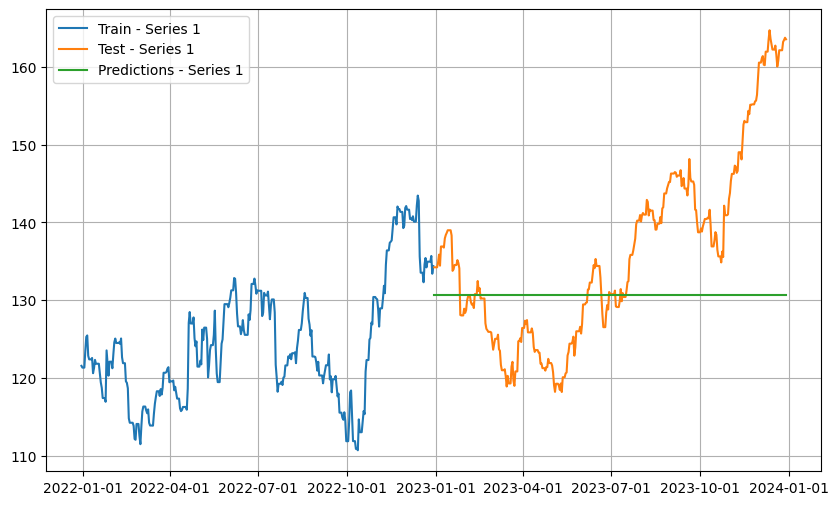

130.62740631103514


In [92]:
param_grid = {
    'window_length': [2, 3, 5, 9, 10, 15, 20, 30, 45, 60, 90]
}

cv = ExpandingWindowSplitter(initial_window=3270, step_length=15, fh=90)

model = NaiveForecaster(strategy='mean', sp=1) #Seasonal periodicity to use in the seasonal forecasting. None=1.

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(y_train)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = grid_search.predict(fh_n)

# Access the cross-validation results
cv_results = grid_search.cv_results_
display(cv_results)
functions.plot_and_print_prediction(y_train, y_test, y_pred)

In [42]:
# error metrics:
model_name = 'SMA_gscv_win90_t0'
error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0  SMA_gscv_win90_t0  13.083018  10.022836  0.070315

In [43]:
#storing predictions
predictions_df[model_name] = y_test.values
predictions_df.head()

y_test  SMA_gscv_win90_t0
2022-12-30  134.223755         134.223755
2022-12-31  134.223755         134.223755
2023-01-01  134.223755         134.223755
2023-01-02  134.223755         134.223755
2023-01-03  134.852524         134.852524

In [44]:
# drop col from scoring as needed
#model_scoring.drop(index=9, inplace=True)
#model_scoring

### (t1) simple moving average model (SMA) using sktime naive forecaster + gridsearch

In [45]:
param_grid = {
    'window_length': [2, 3, 5, 9, 10, 15, 20, 30, 45, 60, 90]
}

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, fh=90)

model = NaiveForecaster(strategy='mean', sp=1) #Seasonal periodicity to use in the seasonal forecasting. None=1.

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(train_transformed)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = grid_search.predict(fh_n)

y_pred = differencer.inverse_transform(y_pred_transformed)

# Access the cross-validation results
cv_results = grid_search.cv_results_
display(cv_results)
functions.plot_and_print_prediction(y_train, y_test, y_pred)

{'window_length': 90}


mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                            3.205713e+14       0.001161        0.001544   
1                            4.669173e+14       0.001061        0.001454   
2                            6.804386e+14       0.001186        0.001687   
3                            5.465279e+14       0.001152        0.001570   
4                            5.110511e+14       0.001218        0.001545   
5                            4.482310e+14       0.001141        0.001539   
6                            3.562592e+14       0.001160        0.001546   
7                            2.696623e+14       0.001288        0.001517   
8                            1.951821e+14       0.000743        0.000975   
9                            1.779478e+14       0.000715        0.000931   
10                           1.069470e+14       0.000714        0.000927   

                   params  rank_test_MeanAbsolutePercentageError  
0    {'window_length': 2}                                    5.0  
1    {'window_length': 3}                                    8.0  
2    {'window_length': 5}                                   11.0  
3    {'window_length': 9}                                   10.0  
4   {'window_length': 10}                                    9.0  
5   {'window_length': 15}                                    7.0  
6   {'window_length': 20}                                    6.0  
7   {'window_length': 30}                                    4.0  
8   {'window_length': 45}                                    3.0  
9   {'window_length': 60}                                    2.0  
10  {'window_length': 90}                                    1.0

134.63605456882053


In [46]:
# error metrics:
model_name = 'SES_gscv_trend0_s00_sp365_t1'
error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0             SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1  SES_gscv_trend0_s00_sp365_t1  47.875986  44.109975  0.321189

In [47]:
#storing predictions
predictions_df[model_name] = y_test.values
predictions_df.head()

y_test  SMA_gscv_win90_t0  SES_gscv_trend0_s00_sp365_t1
2022-12-30  134.223755         134.223755                    134.223755
2022-12-31  134.223755         134.223755                    134.223755
2023-01-01  134.223755         134.223755                    134.223755
2023-01-02  134.223755         134.223755                    134.223755
2023-01-03  134.852524         134.852524                    134.852524

### t(0) simple exponential smoothing (SES) * gridsearch 

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/_smoothers.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  b = (b - lb) / (ub - lb)
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/_smoothers.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  b = (b - lb) / (ub - lb)
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/_smoothers.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  b = (b - lb) / (ub - lb)
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/_smoothers.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  b = (b - lb) / (ub - lb)
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/pyth

{'smoothing_level': 0.9, 'sp': 365, 'trend': None}


mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                                 0.148628       0.031261        0.016988   
1                                      NaN       0.052433        0.014038   
2                                 0.119864       0.017185        0.007101   
3                                 0.148628       0.031649        0.014929   
4                                      NaN       0.054074        0.022648   
..                                     ...            ...             ...   
115                               0.068864       0.039227        0.016330   
116                               0.066575       0.004455        0.003330   
117                               0.067098       0.018644        0.014964   
118                               0.068864       0.035674        0.012401   
119                               0.066575       0.004261        0.004354   

                                                params  \
0    {'smoothing_level': 0.0, 'sp': 365, 'trend': '...   
1    {'smoothing_level': 0.0, 'sp': 365, 'trend': '...   
2    {'smoothing_level': 0.0, 'sp': 365, 'trend': N...   
3    {'smoothing_level': 0.0, 'sp': 12, 'trend': 'a...   
4    {'smoothing_level': 0.0, 'sp': 12, 'trend': 'm...   
..                                                 ...   
115  {'smoothing_level': 0.9, 'sp': 1, 'trend': 'mul'}   
116   {'smoothing_level': 0.9, 'sp': 1, 'trend': None}   
117  {'smoothing_level': 0.9, 'sp': 2, 'trend': 'add'}   
118  {'smoothing_level': 0.9, 'sp': 2, 'trend': 'mul'}   
119   {'smoothing_level': 0.9, 'sp': 2, 'trend': None}   

     rank_test_MeanAbsolutePercentageError  
0                                    106.5  
1                                      NaN  
2                                     94.5  
3                                    106.5  
4                                      NaN  
..                                     ...  
115                                   30.5  
116                                    2.5  
117                                    6.5  
118                                   30.5  
119                                    2.5  

[120 rows x 5 columns]

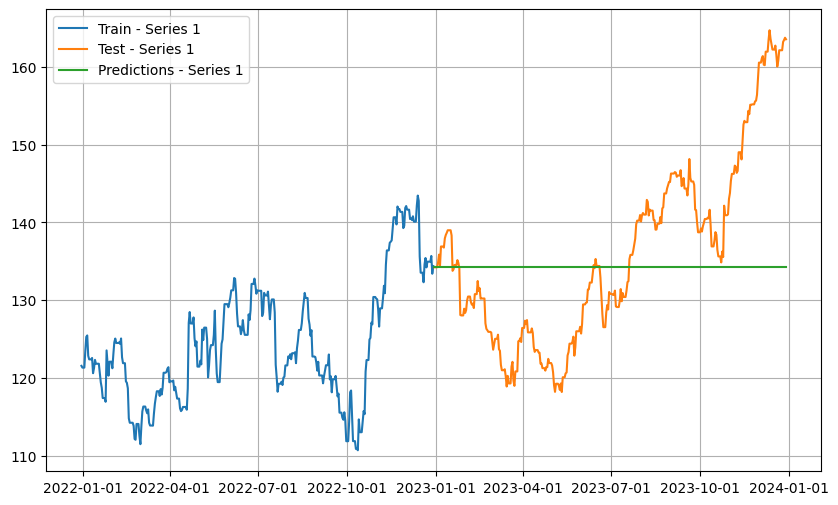

134.30876405199183


In [48]:
#'sp': [365, 12, 1, 2] #4, 6, 8
param_grid = {
    'trend': ['add', 'mul', None],
    'damped_trend': [True, False],
    'sp': [365, 12, 1, 2],
    'smoothing_level': [0.0, 0.2, 0.5]
}

param_grid = {
    'smoothing_level': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'sp': [365, 12, 1, 2],
    'trend': ['add', 'mul', None]
}

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, step_length=30, fh=90)

model = ExponentialSmoothing() #(can use box-cox).

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(y_train)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = grid_search.predict(fh_n)

# Access the cross-validation results
cv_results = grid_search.cv_results_
display(cv_results)
functions.plot_and_print_prediction(y_train, y_test, y_pred)

In [49]:
# error metrics:
#'SES_gscv_damp0_trend0_sp365_t0'
model_name = 'SES_gscv_alpha09_t0'
error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0             SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1  SES_gscv_trend0_s00_sp365_t1  47.875986  44.109975  0.321189
2           SES_gscv_alpha09_t0  12.013235   9.618793  0.069187

In [50]:
#storing predictions
predictions_df[model_name] = y_test.values
predictions_df.head()

y_test  SMA_gscv_win90_t0  SES_gscv_trend0_s00_sp365_t1  \
2022-12-30  134.223755         134.223755                    134.223755   
2022-12-31  134.223755         134.223755                    134.223755   
2023-01-01  134.223755         134.223755                    134.223755   
2023-01-02  134.223755         134.223755                    134.223755   
2023-01-03  134.852524         134.852524                    134.852524   

            SES_gscv_alpha09_t0  
2022-12-30           134.223755  
2022-12-31           134.223755  
2023-01-01           134.223755  
2023-01-02           134.223755  
2023-01-03           134.852524

### --> t(1) simple exponential smoothing (SES) * gridsearch 

#### SES loop

In [51]:
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations

from sktime.forecasting.exp_smoothing import ExponentialSmoothing

Model with smoothing level = 0.0
                       Model       RMSE        MAE      MAPE
0  SES smoothing level = 0.0  28.680703  26.106045  0.185873


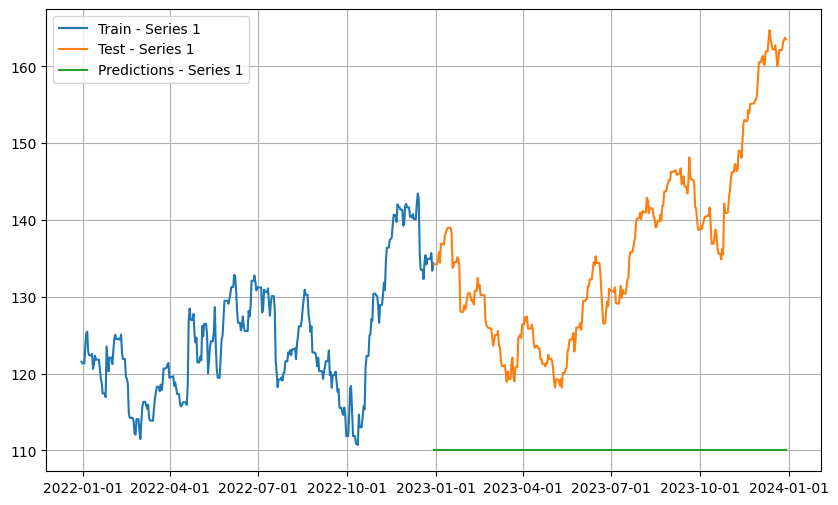

110.00845688031312


Model with smoothing level = 0.05
                        Model       RMSE       MAE     MAPE
0  SES smoothing level = 0.05  11.876774  9.687219  0.07061


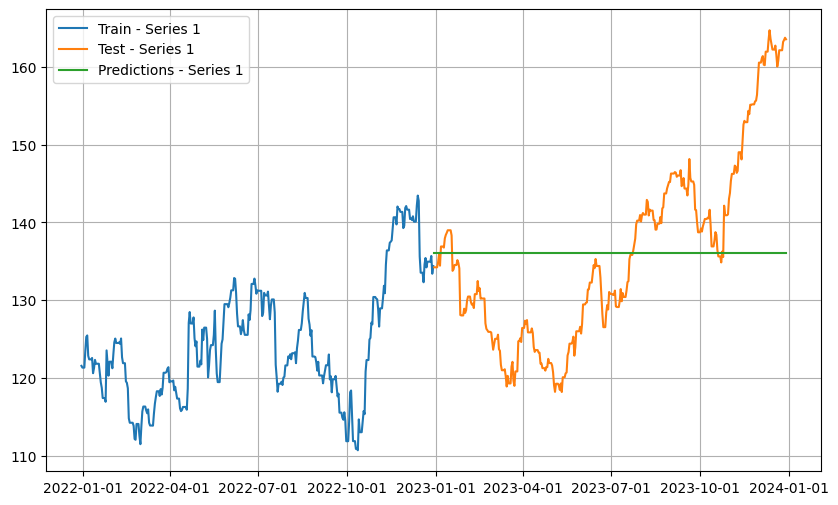

136.08937526202982


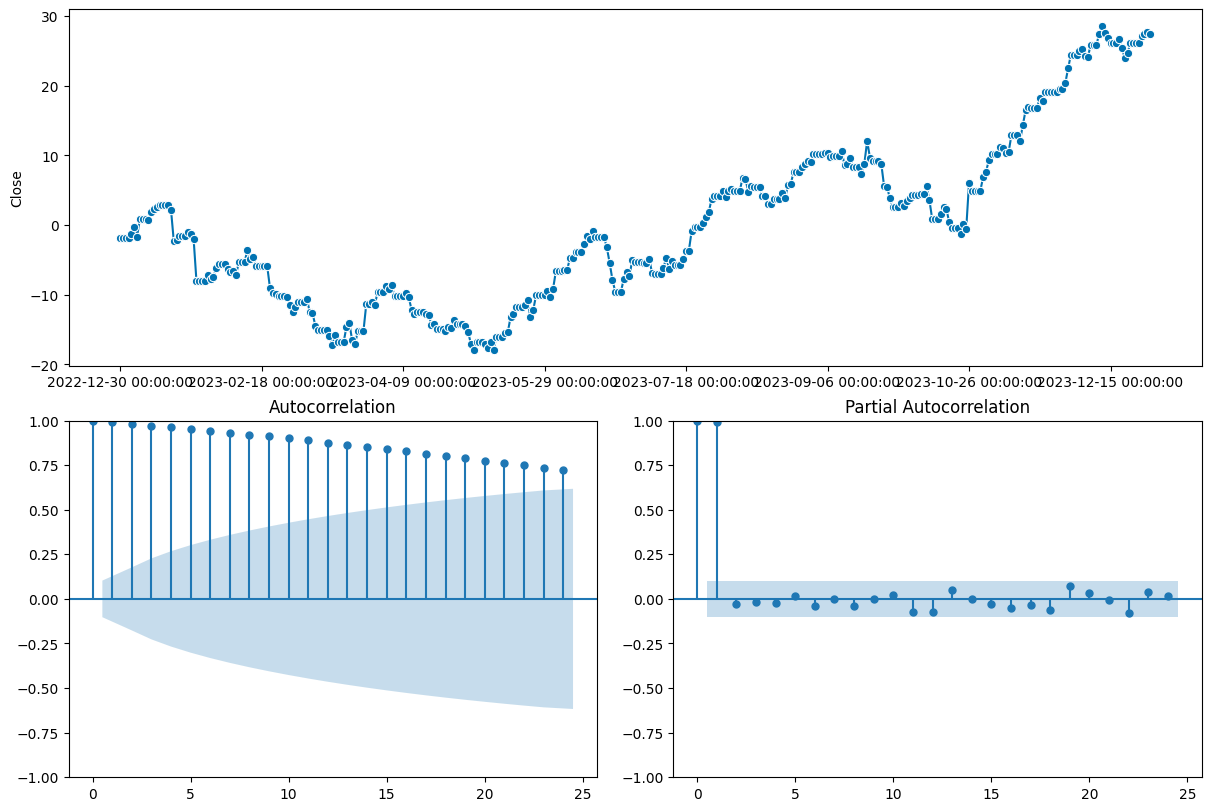

Model with smoothing level = 0.1
                       Model       RMSE       MAE      MAPE
0  SES smoothing level = 0.1  11.881036  9.661336  0.070268


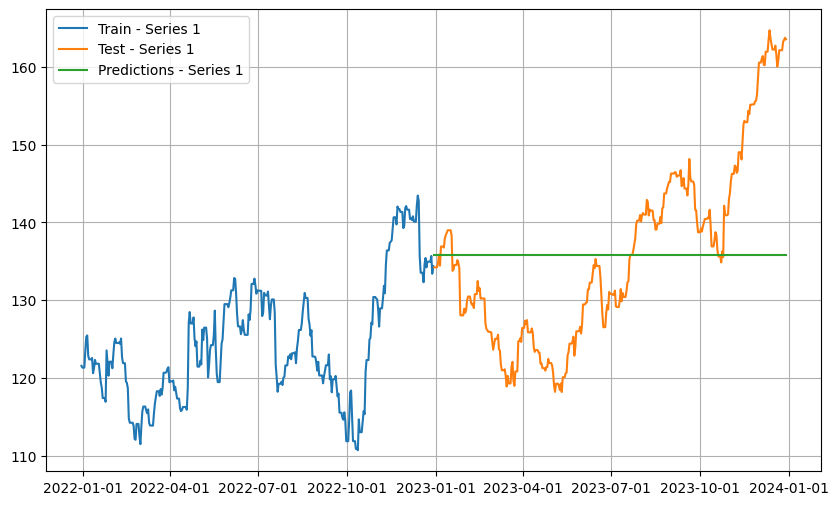

135.79531614781587


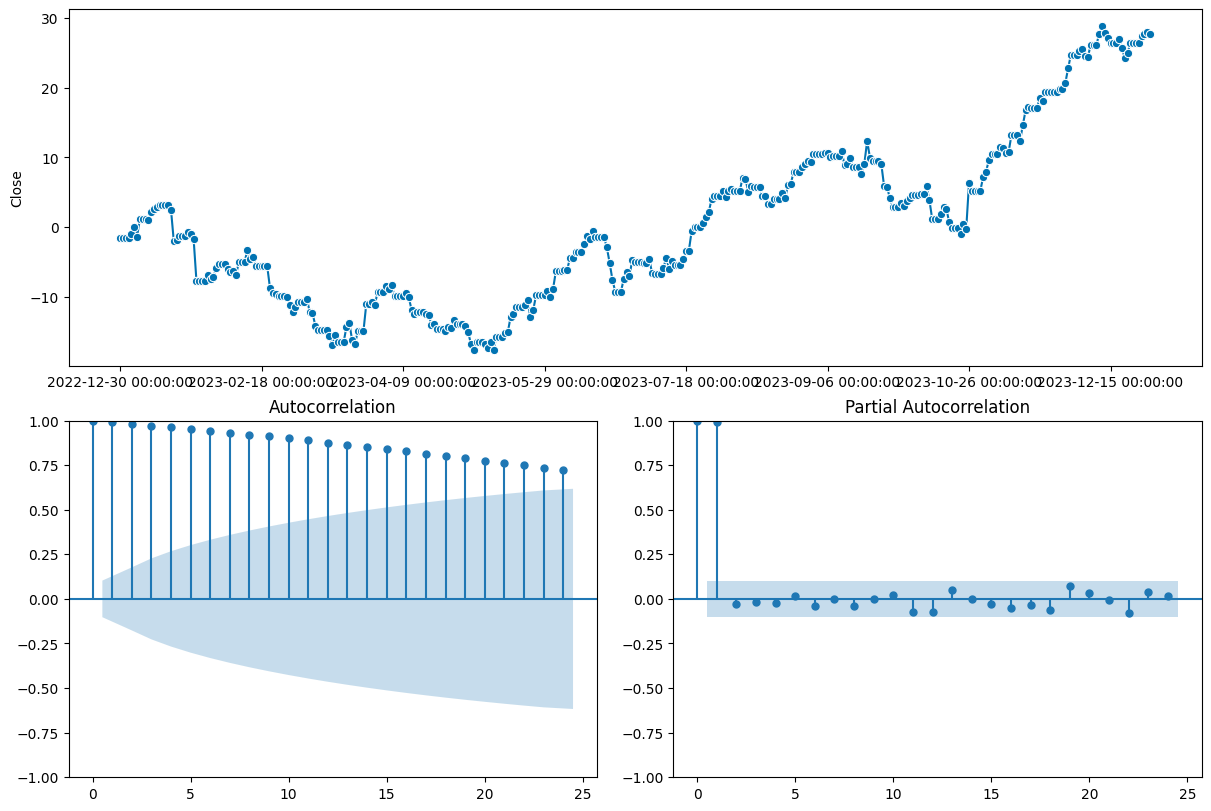

Model with smoothing level = 0.15
                        Model       RMSE       MAE      MAPE
0  SES smoothing level = 0.15  11.918361  9.627552  0.069669


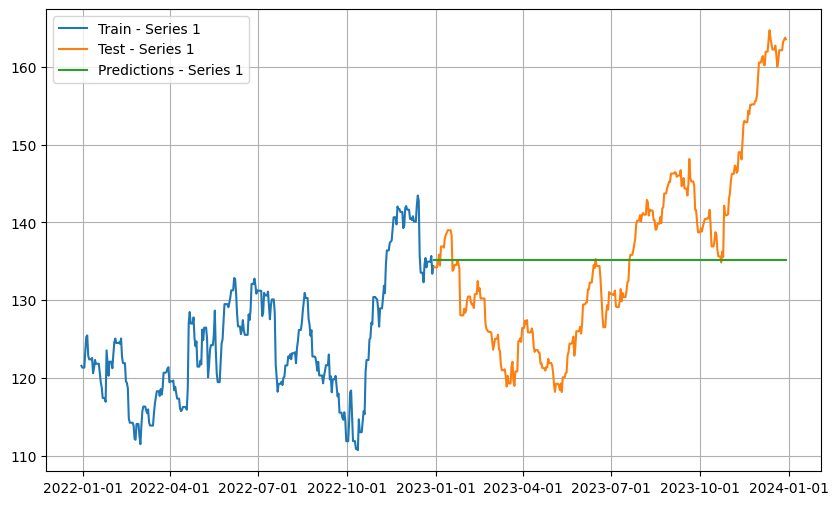

135.1194177747709


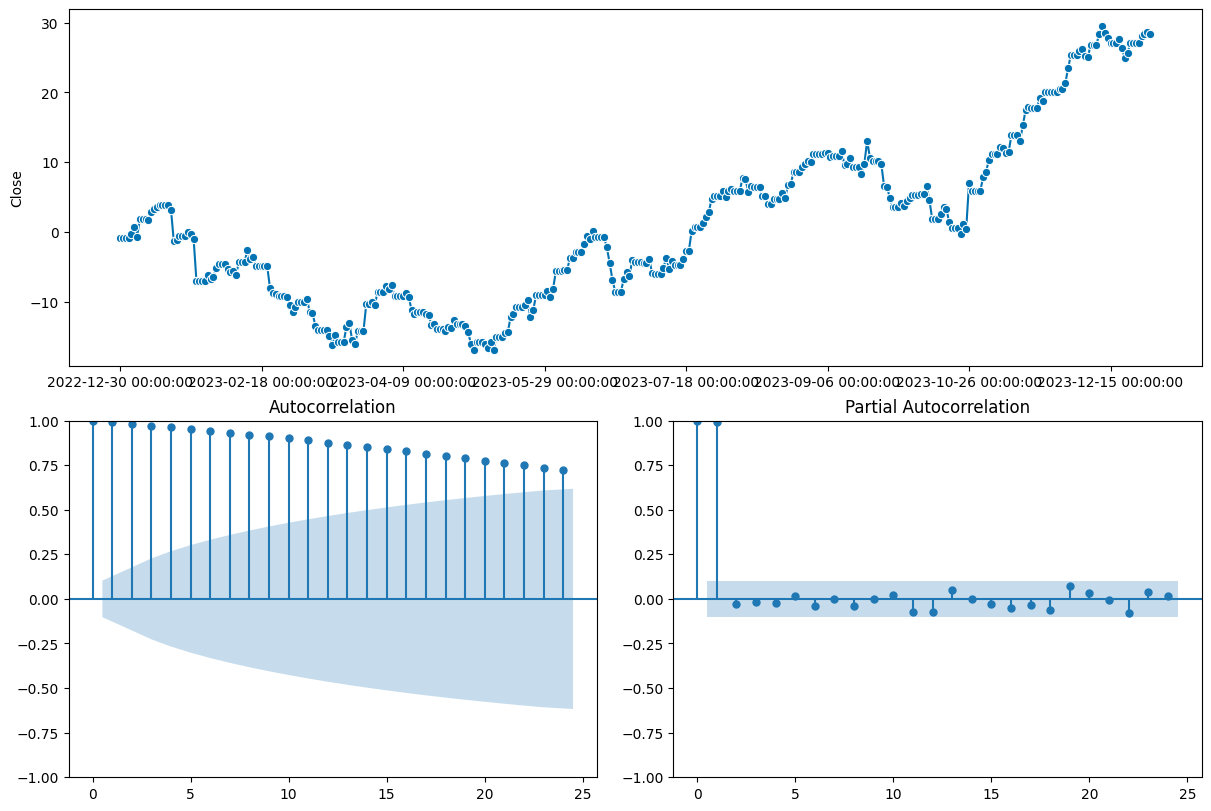

Model with smoothing level = 0.2
                       Model       RMSE     MAE      MAPE
0  SES smoothing level = 0.2  11.951416  9.6182  0.069425


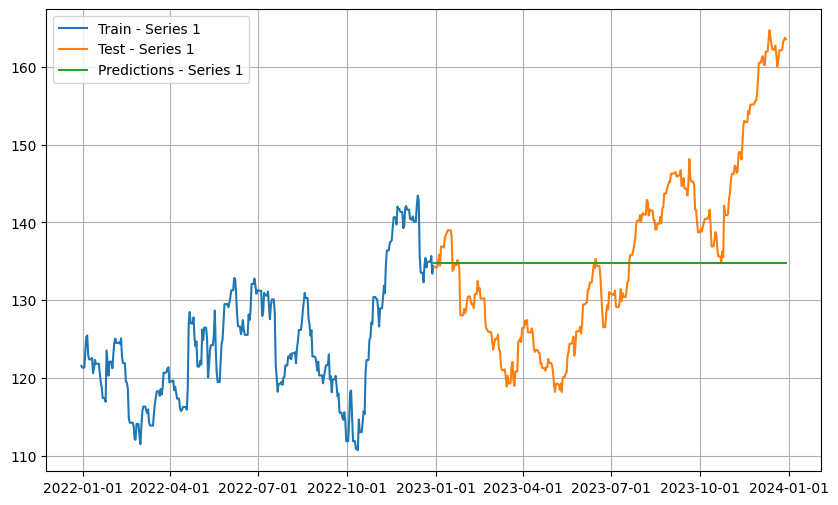

134.7806322607477


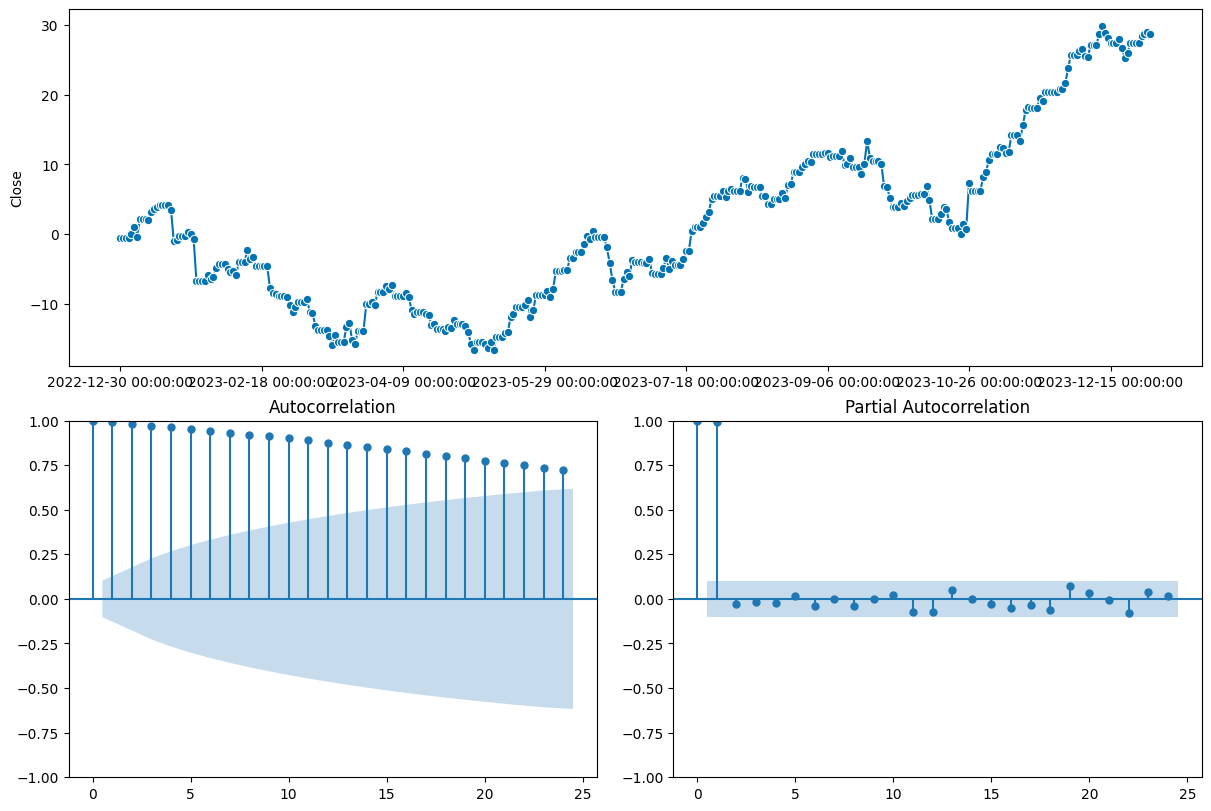

Model with smoothing level = 0.25
                        Model       RMSE       MAE      MAPE
0  SES smoothing level = 0.25  11.970083  9.616036  0.069328


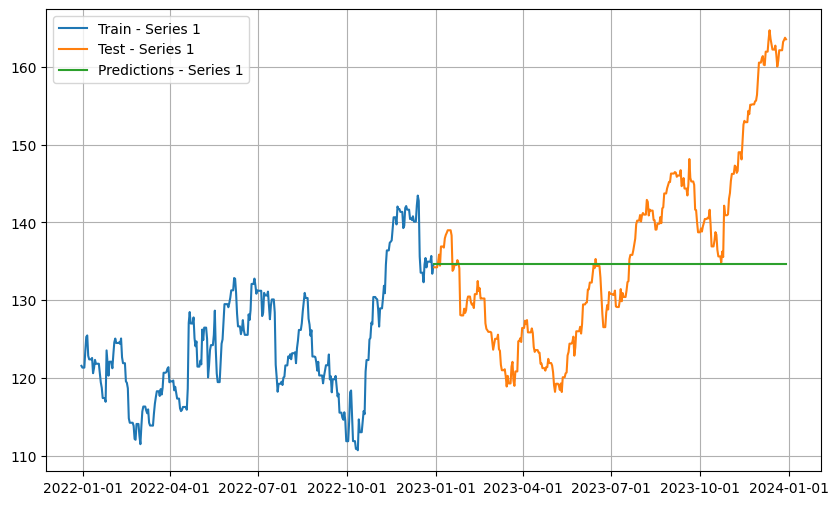

134.62260847428564


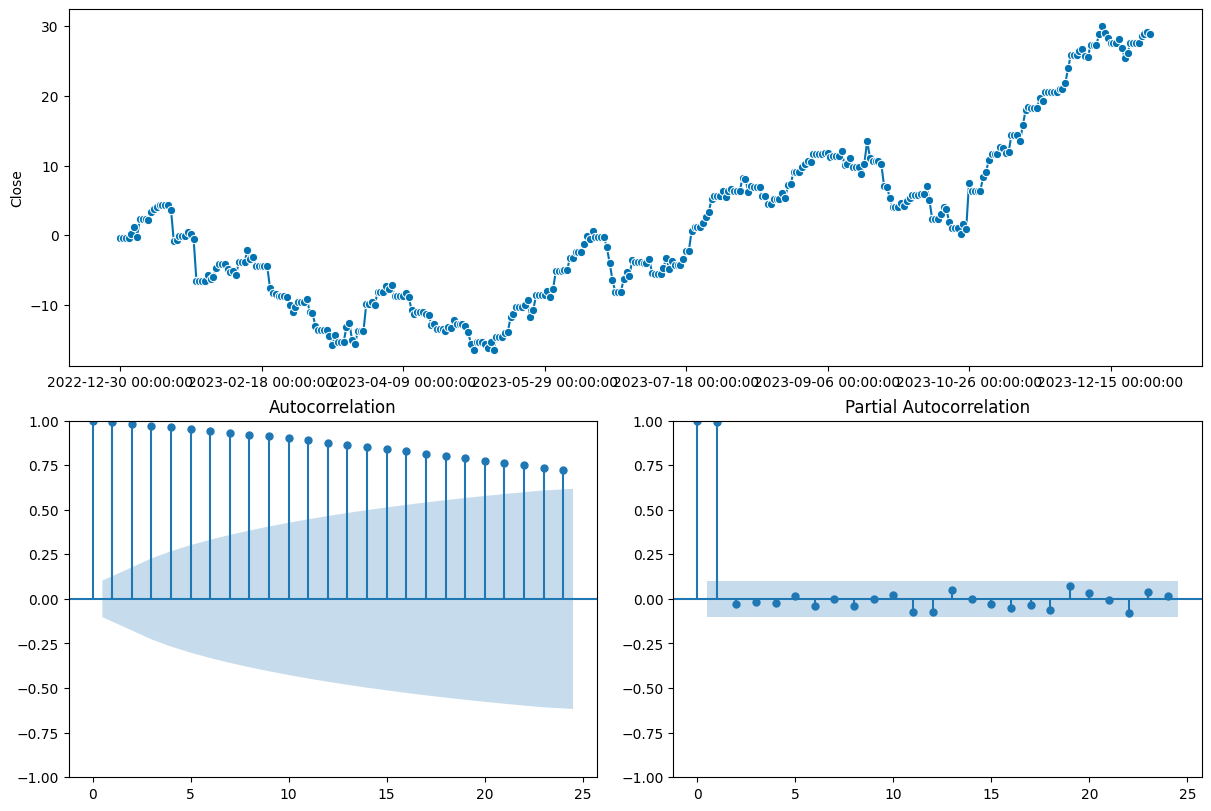

Model with smoothing level = 0.3
                       Model       RMSE      MAE      MAPE
0  SES smoothing level = 0.3  11.980596  9.61491  0.069277


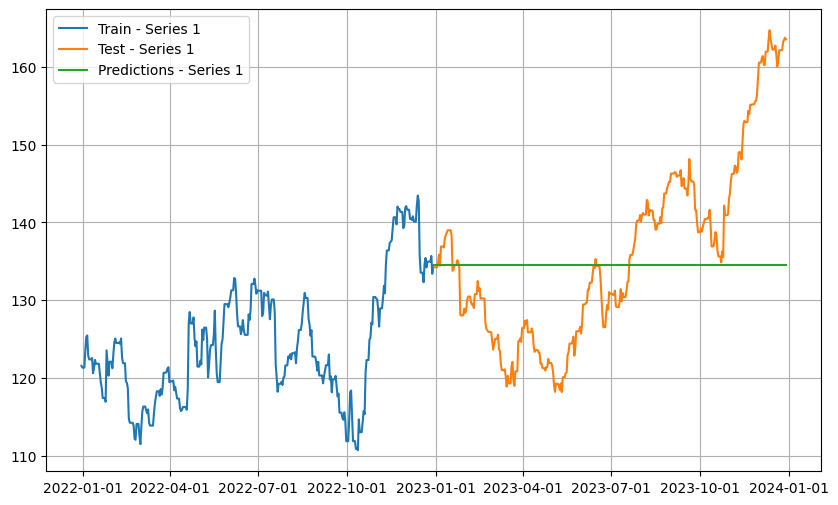

134.5404770982819


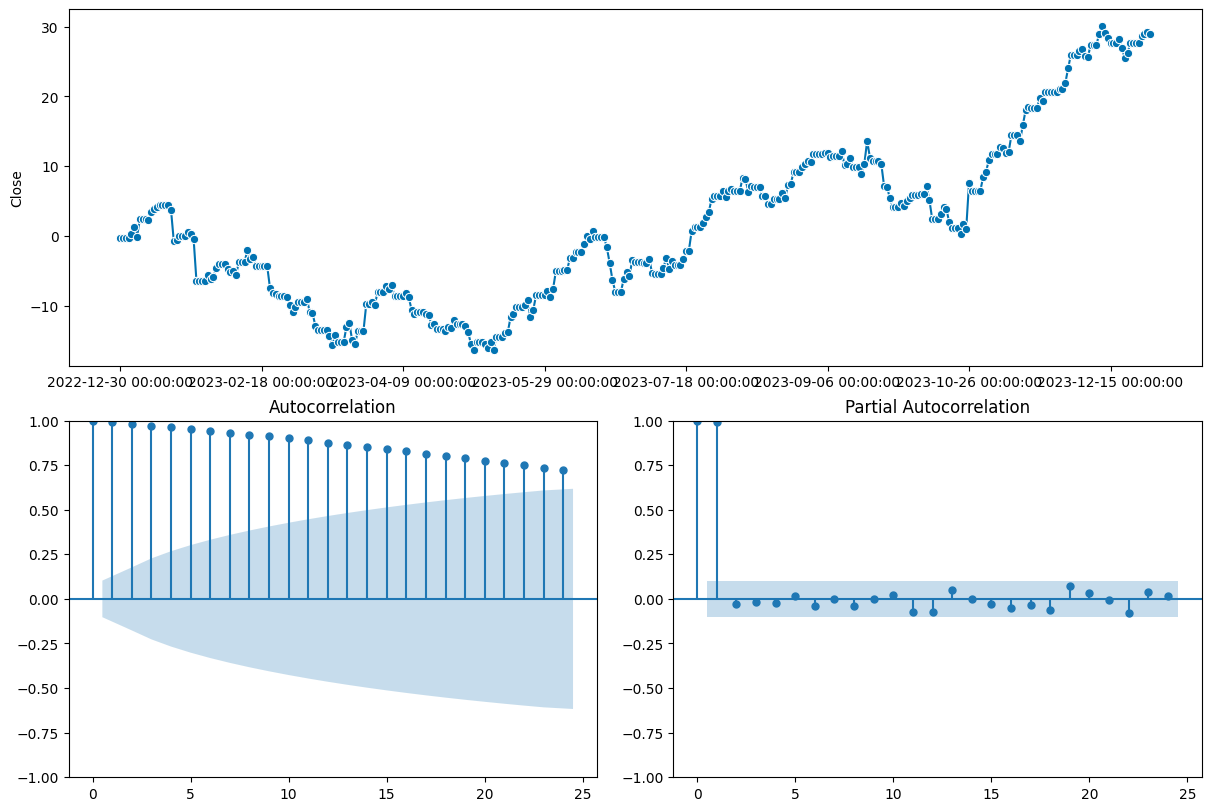

In [52]:
# create iterable model to find best smoothing level(alpha for SES model

model_scoring_SES = pd.DataFrame()

for i in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    print(f'Model with smoothing level = {i}') 
    model = ExponentialSmoothing(smoothing_level=i)
    fh_n = ForecastingHorizon(y_test.index, is_relative=False)
    # Fit the model
    model.fit(y_train)
    # Make a prediction
    y_pred = model.predict(fh=fh_n) 
    #y_pred = differencer.inverse_transform(y_pred_transformed)

    model_name = f'SES smoothing level = {i}'
    error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
    print(error_metrics_result)
    model_scoring_SES = pd.concat([model_scoring_SES, error_metrics_result], ignore_index=True)

    functions.plot_and_print_prediction(y_train, y_test, y_pred)
    residuals = y_test - y_pred
    fig, ax = plot_correlations(residuals)
    plt.show()

Model with smoothing level = 0.0
                       Model       RMSE       MAE      MAPE
0  SES smoothing level = 0.0  11.626908  9.350498  0.067629


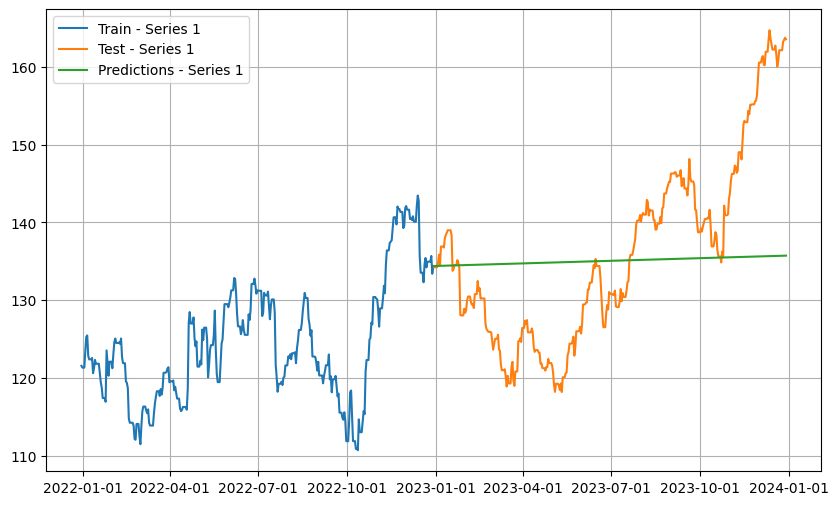

134.38937435400857


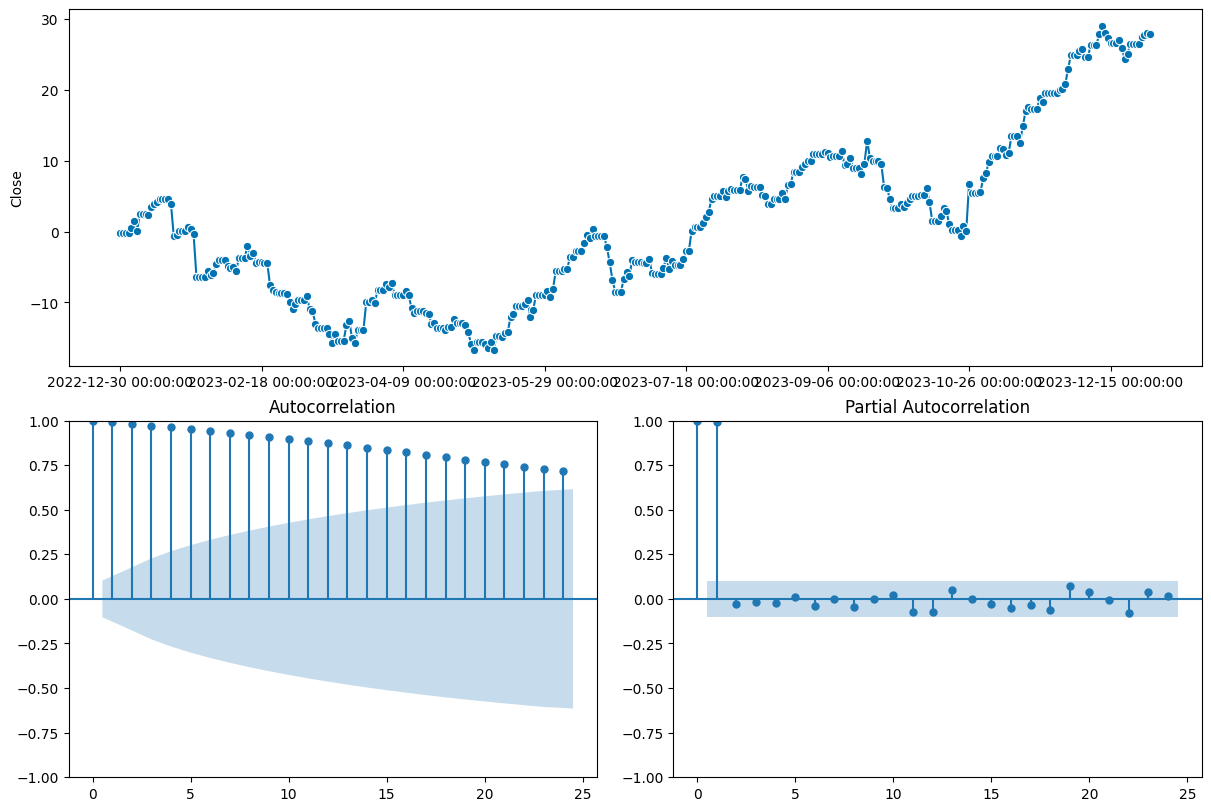

Model with smoothing level = 0.1
                       Model       RMSE        MAE     MAPE
0  SES smoothing level = 0.1  40.526283  30.614145  0.21155


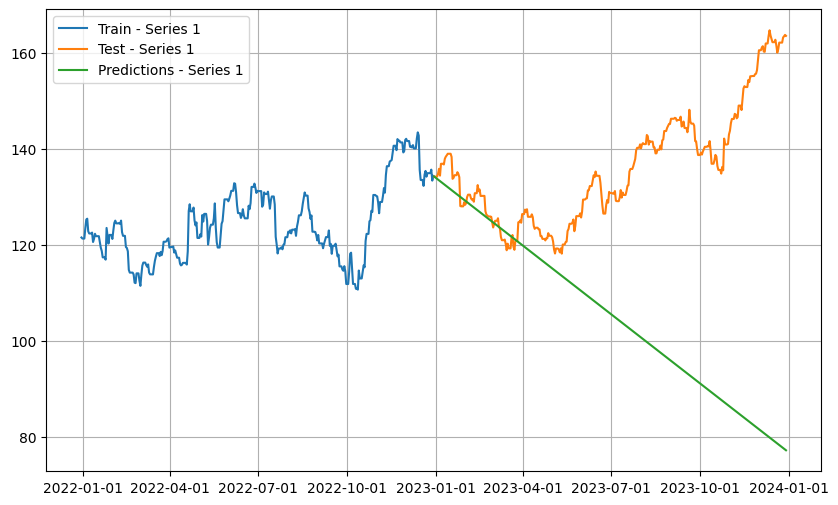

134.22908895015587


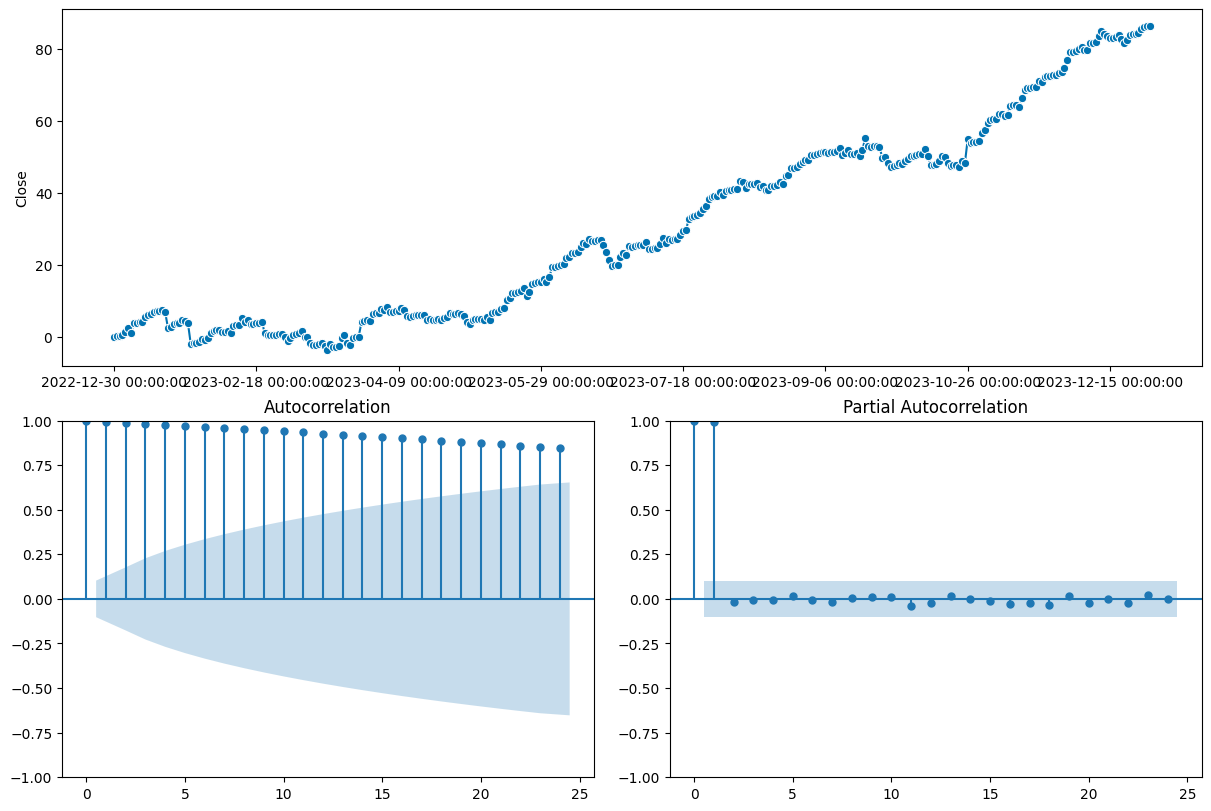

Model with smoothing level = 0.2
                       Model       RMSE        MAE      MAPE
0  SES smoothing level = 0.2  28.873496  21.106649  0.144948


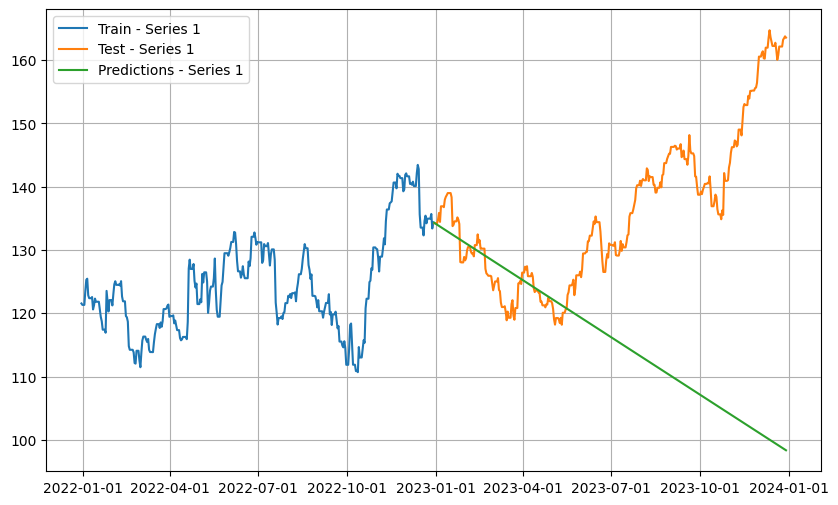

134.28698152221543


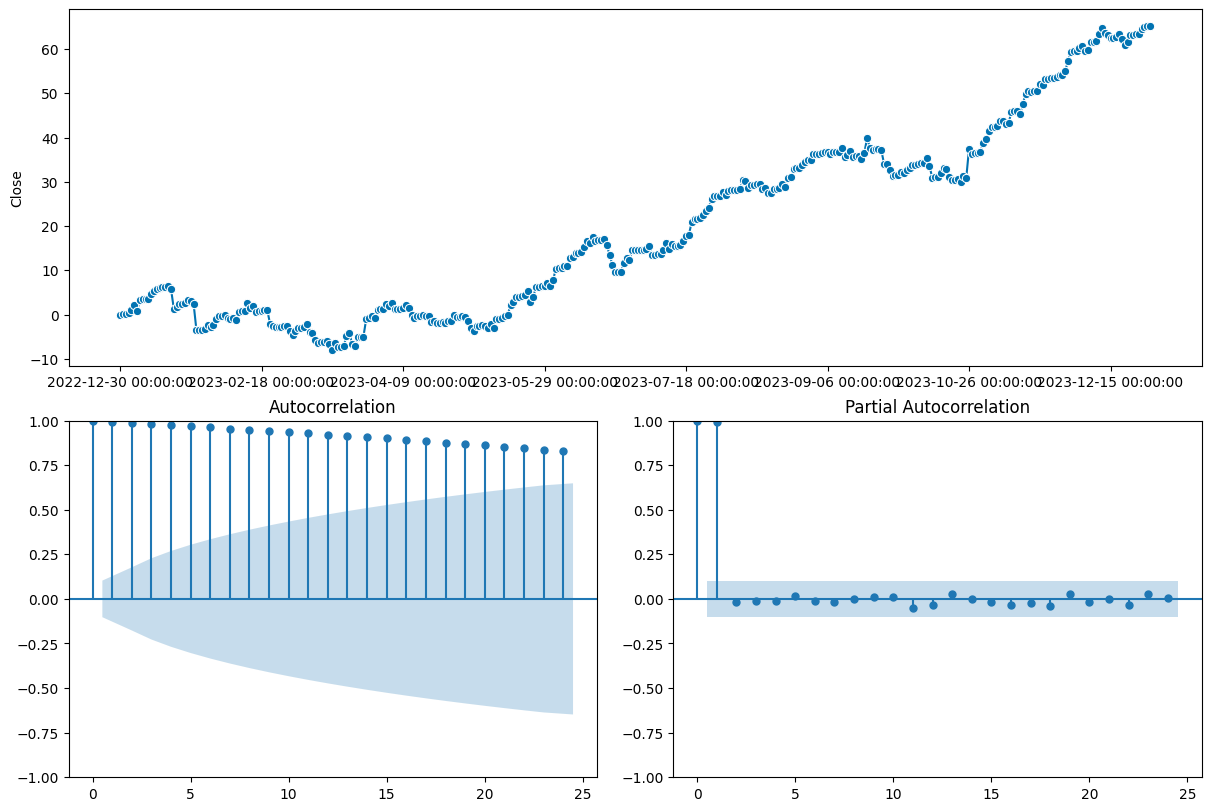

Model with smoothing level = 0.3
                       Model       RMSE       MAE      MAPE
0  SES smoothing level = 0.3  22.616709  16.69359  0.115064


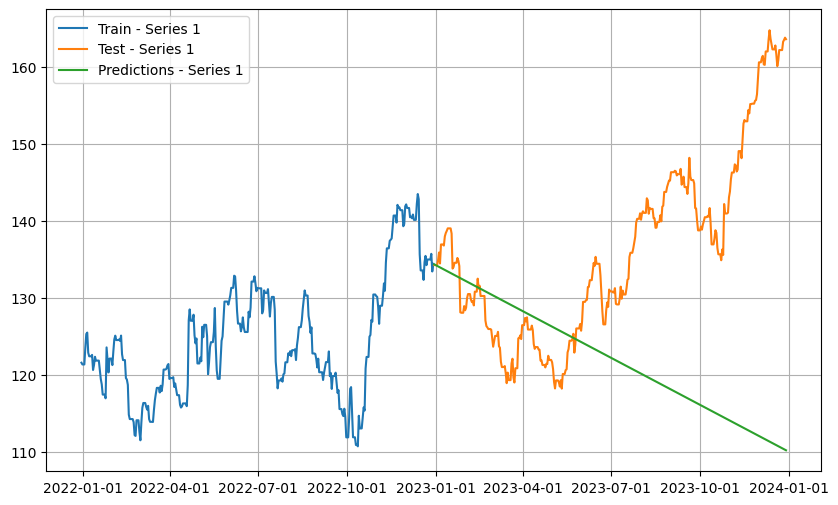

134.31938362919612


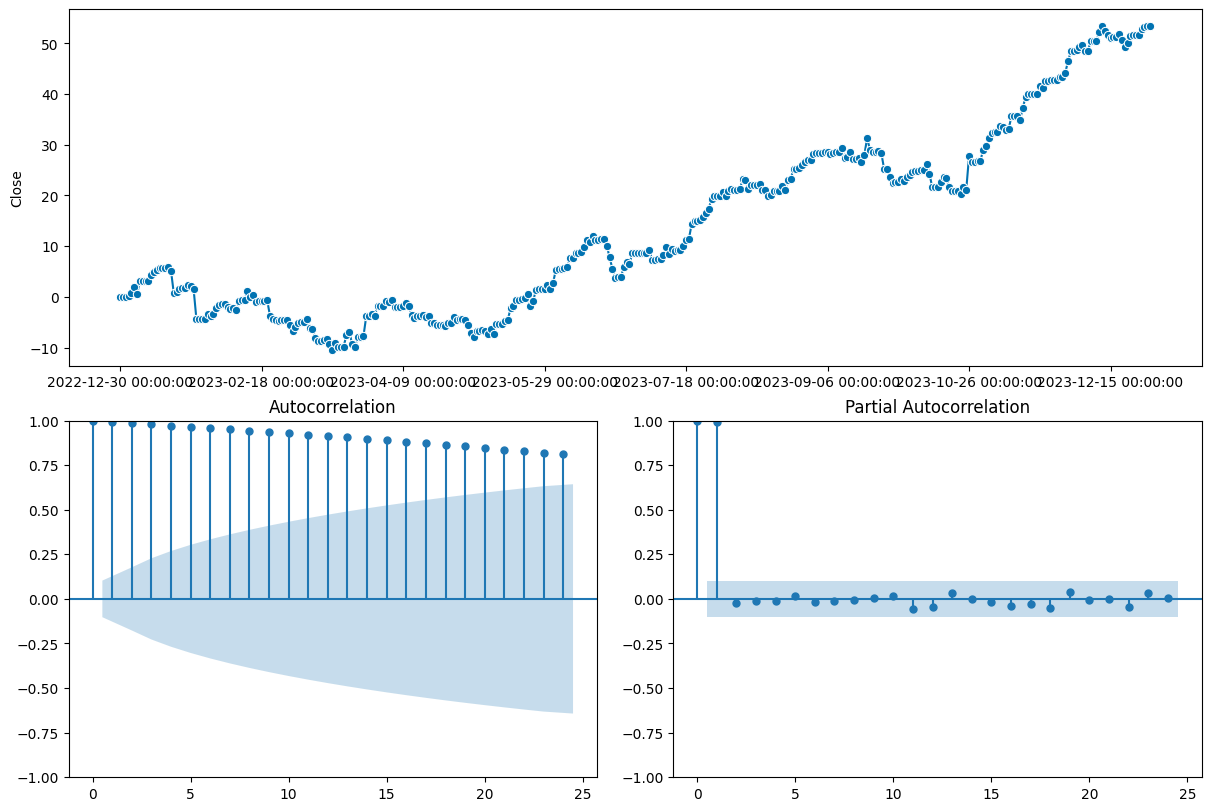

Model with smoothing level = 0.4
                       Model       RMSE        MAE      MAPE
0  SES smoothing level = 0.4  17.500218  13.236998  0.092135


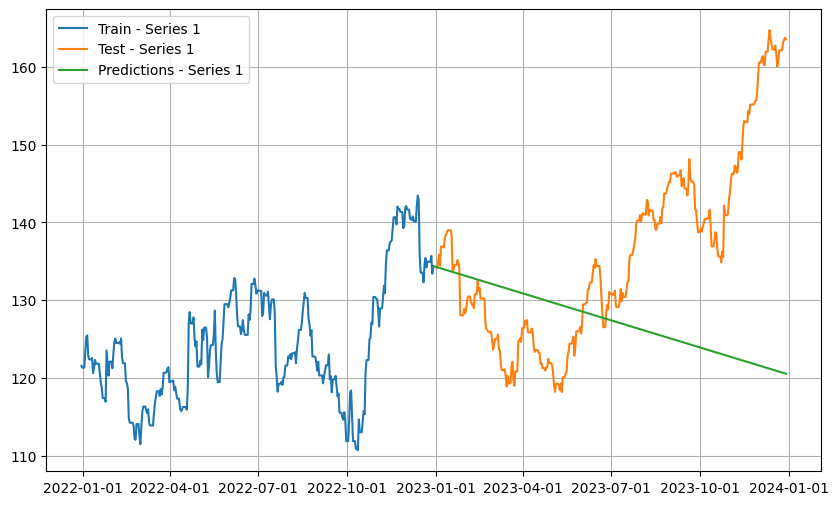

134.3477643770152


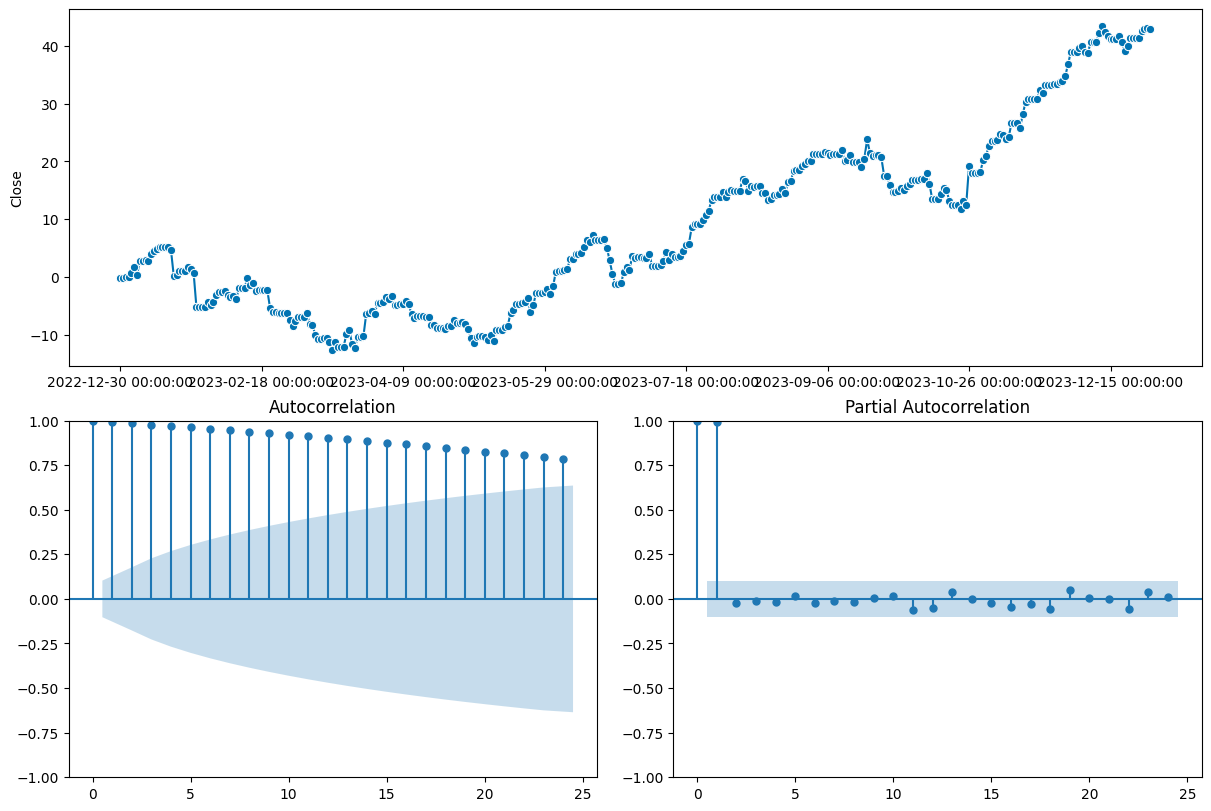

Model with smoothing level = 0.5
                       Model       RMSE       MAE      MAPE
0  SES smoothing level = 0.5  10.521719  8.570503  0.063502


134.40513519611807


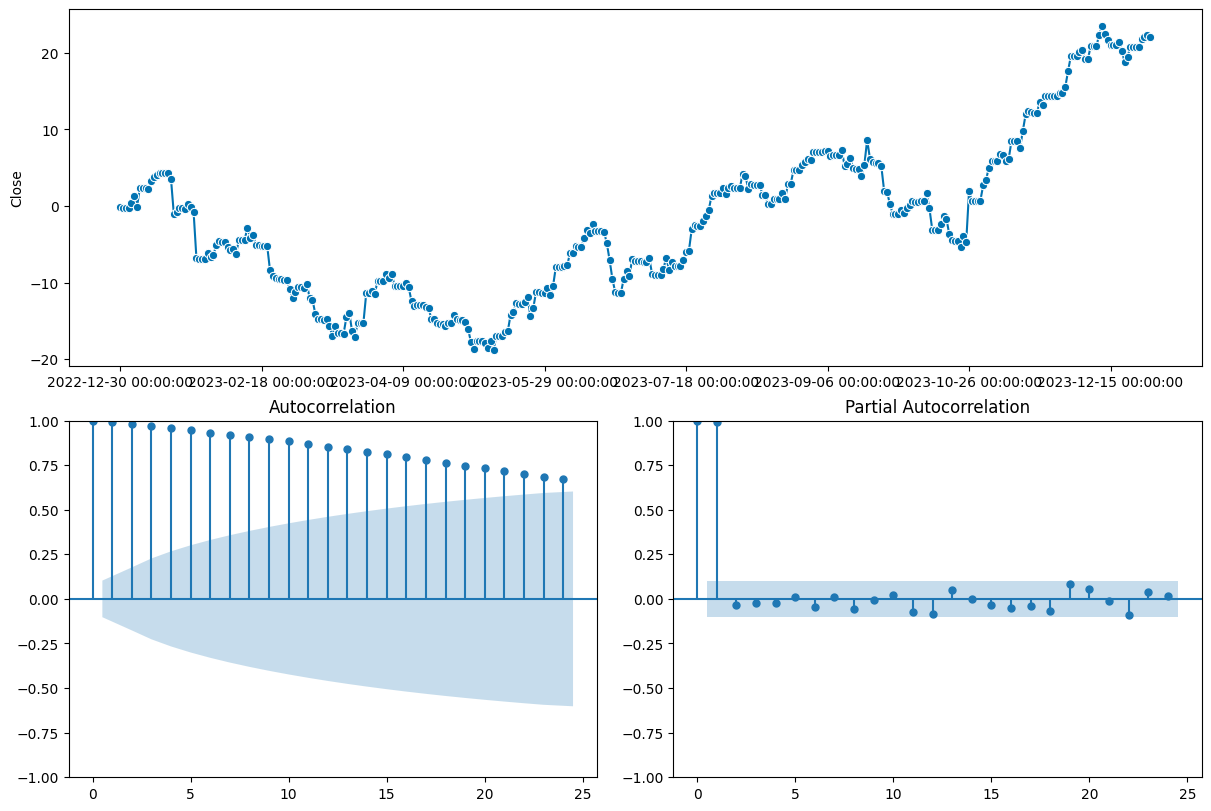

Model with smoothing level = 0.6
                       Model       RMSE        MAE    MAPE
0  SES smoothing level = 0.6  21.333005  19.889073  0.1486


134.50306802850537


Model with smoothing level = 0.7
                       Model       RMSE        MAE      MAPE
0  SES smoothing level = 0.7  49.841393  45.846609  0.333564


134.64557722805887


Model with smoothing level = 0.8
                       Model       RMSE        MAE     MAPE
0  SES smoothing level = 0.8  89.570071  80.675886  0.58176


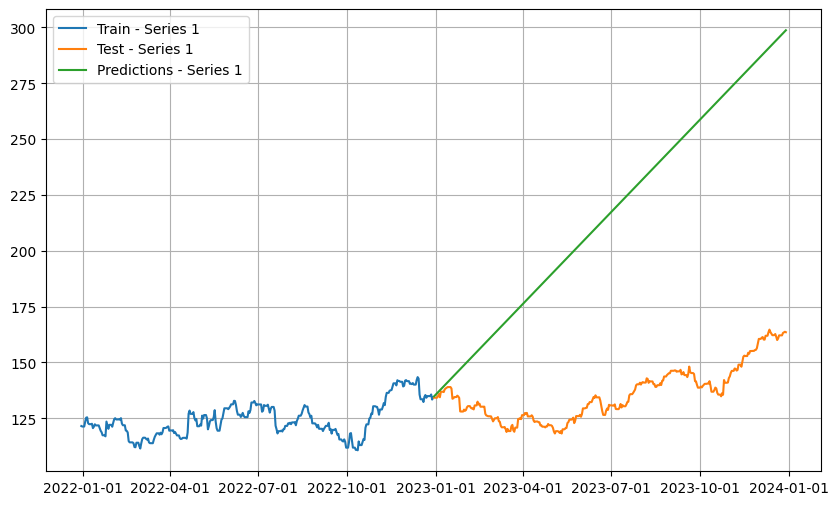

134.8360104474805


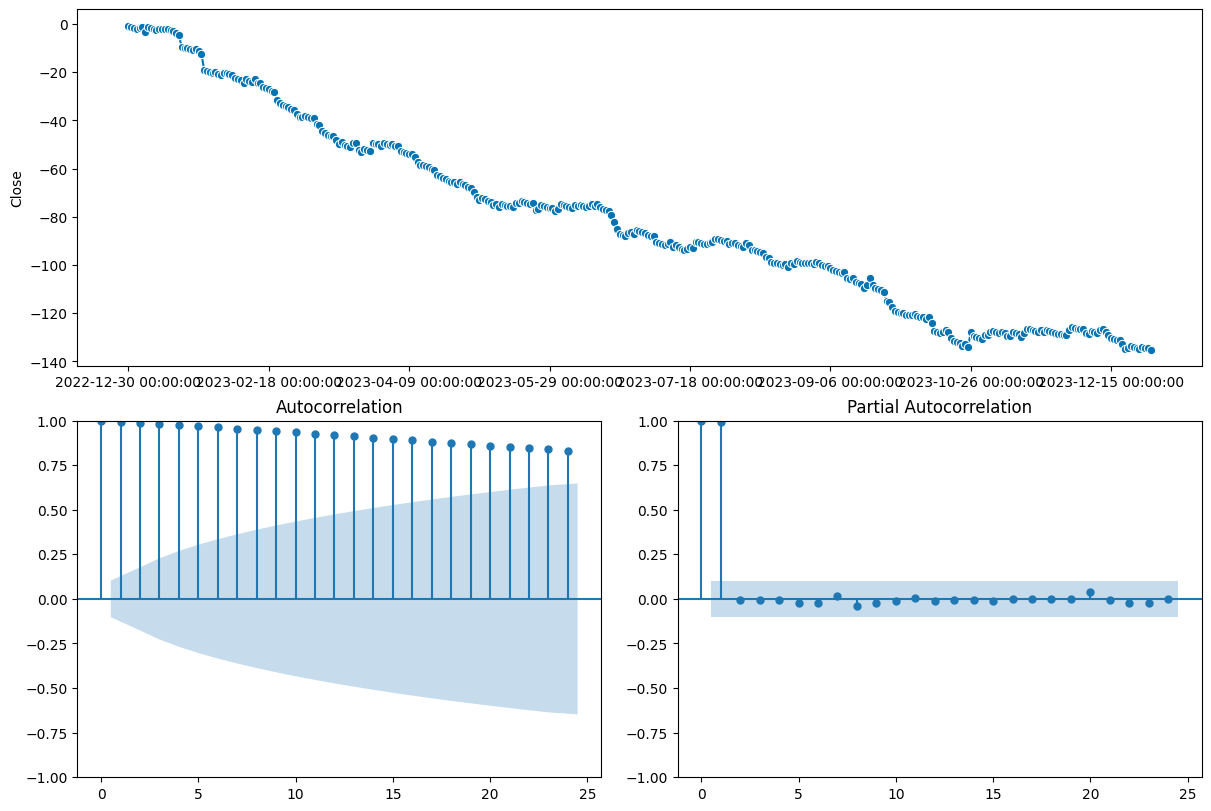

Model with smoothing level = 0.9
                       Model       RMSE         MAE      MAPE
0  SES smoothing level = 0.9  140.50342  125.003937  0.897647


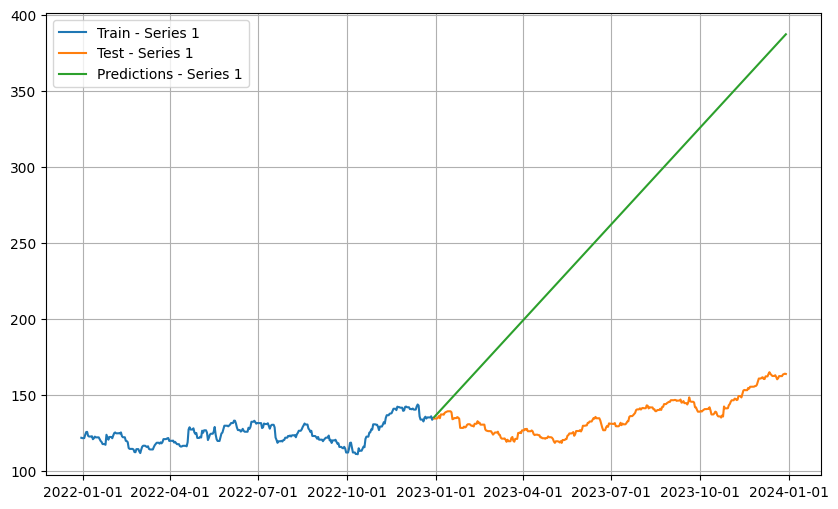

135.0782402312923


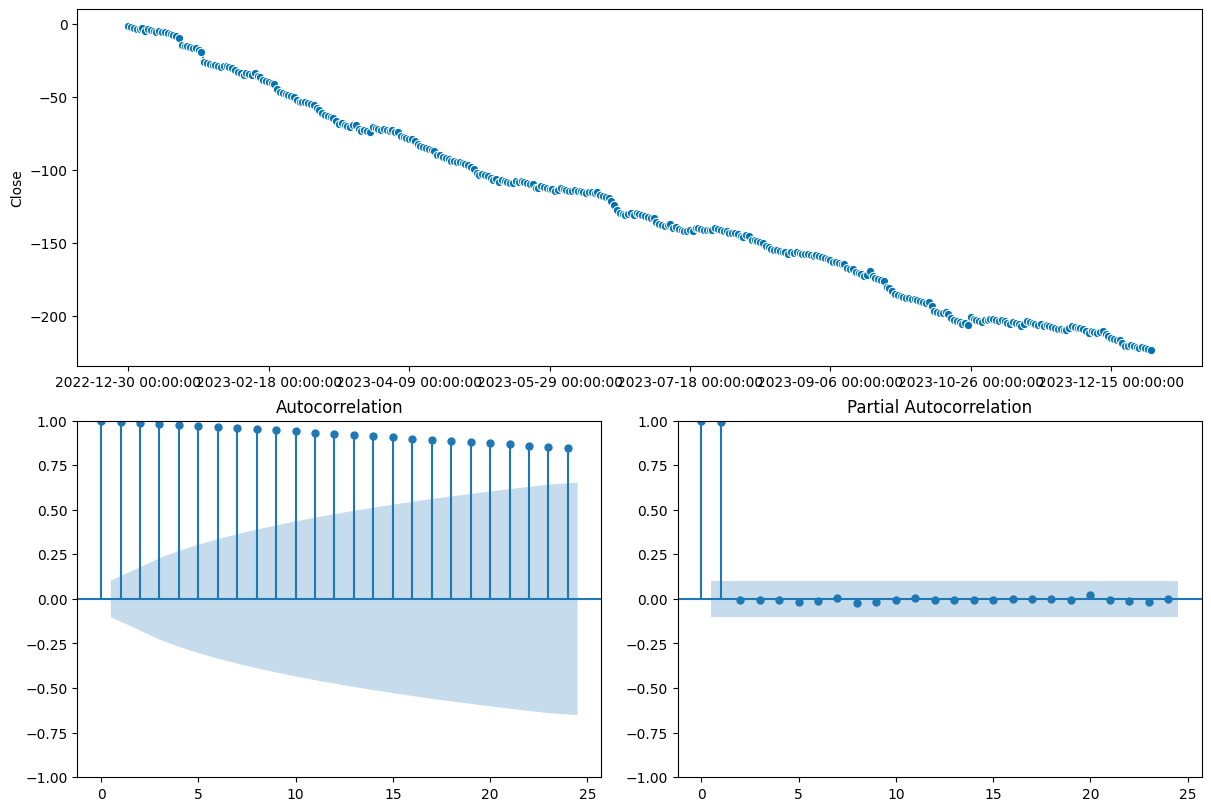

In [53]:
# create iterable model to find best smoothing level(alpha for SES model

model_scoring_SES = pd.DataFrame()

for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(f'Model with smoothing level = {i}') 
    model = ExponentialSmoothing(smoothing_level=i)
    fh_n = ForecastingHorizon(y_test.index, is_relative=False)
    # Fit the model
    model.fit(train_transformed)
    # Make a prediction
    y_pred_transformed = model.predict(fh=fh_n) 
    y_pred = differencer.inverse_transform(y_pred_transformed)

    model_name = f'SES smoothing level = {i}'
    error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
    print(error_metrics_result)
    model_scoring_SES = pd.concat([model_scoring_SES, error_metrics_result], ignore_index=True)

    functions.plot_and_print_prediction(y_train, y_test, y_pred)
    residuals = y_test - y_pred
    fig, ax = plot_correlations(residuals)
    plt.show()

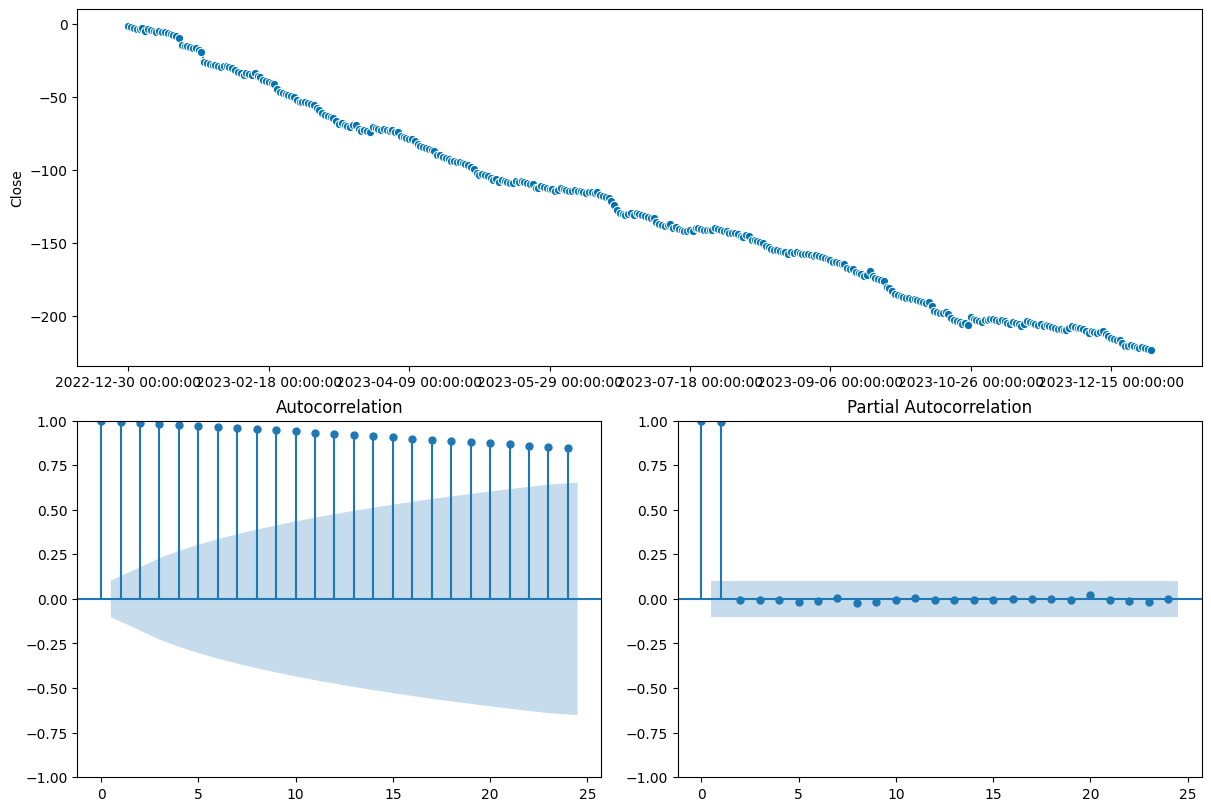

In [54]:
residuals = y_test - y_pred
fig, ax = plot_correlations(residuals)
plt.show()

#### single SES

In [55]:
param_grid = {
    'smoothing_level': [0.3, 0.4, 0.5],
    'sp': [365, 12, 1, 2],
    'trend': ['add', 'mul', None]
}
#     'smoothing_level': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, step_length=15, fh=90)

model = ExponentialSmoothing() #(can use box-cox).

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(train_transformed)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = grid_search.predict(fh_n)

y_pred = differencer.inverse_transform(y_pred_transformed)

# Access the cross-validation results
cv_results = grid_search.cv_results_
display(cv_results)
functions.plot_and_print_prediction(y_train, y_test, y_pred)

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster ExponentialSmoothing failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=3270.
                The score will be set to nan.
                Failed forecaster with parameters: ExponentialSmoothing(smoothing_level=0.3, sp=365, trend='mul').
                
  ret = [fun(x, meta=meta) for x in iter]
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster ExponentialSmoothing failed,
                you can set error_score='raise' in evaluate to see
                the exc

{'smoothing_level': 0.5, 'sp': 365, 'trend': None}


/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster ExponentialSmoothing failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=3270.
                The score will be set to nan.
                Failed forecaster with parameters: ExponentialSmoothing(smoothing_level=0.5, sp=1, trend='mul').
                
  ret = [fun(x, meta=meta) for x in iter]
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster ExponentialSmoothing failed,
                you can set error_score='raise' in evaluate to see
                the excep

mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                            6.571701e+14       0.023607        0.016777   
1                                     NaN            NaN             NaN   
2                            6.433753e+14       0.004866        0.005475   
3                            6.571701e+14       0.021519        0.016044   
4                                     NaN            NaN             NaN   
5                            6.433753e+14       0.005533        0.005342   
6                            6.571701e+14       0.022980        0.016866   
7                                     NaN            NaN             NaN   
8                            6.433753e+14       0.006070        0.005340   
9                            6.571701e+14       0.021961        0.015117   
10                                    NaN            NaN             NaN   
11                           6.433753e+14       0.004782        0.004910   
12                           6.567276e+14       0.023036        0.020350   
13                                    NaN            NaN             NaN   
14                           6.431766e+14       0.003711        0.004622   
15                           6.567276e+14       0.024271        0.017208   
16                                    NaN            NaN             NaN   
17                           6.431766e+14       0.004178        0.003435   
18                           6.567276e+14       0.023069        0.023947   
19                                    NaN            NaN             NaN   
20                           6.431766e+14       0.007519        0.006941   
21                           6.567276e+14       0.019940        0.015743   
22                                    NaN            NaN             NaN   
23                           6.431766e+14       0.005517        0.006234   
24                           6.313826e+14       0.024833        0.019506   
25                                    NaN            NaN             NaN   
26                           6.183619e+14       0.005584        0.007444   
27                           6.313826e+14       0.020168        0.015893   
28                                    NaN            NaN             NaN   
29                           6.183619e+14       0.006538        0.005919   
30                           6.313826e+14       0.019381        0.015952   
31                                    NaN            NaN             NaN   
32                           6.183619e+14       0.003871        0.004890   
33                           6.313826e+14       0.018045        0.015184   
34                                    NaN            NaN             NaN   
35                           6.183619e+14       0.003694        0.003746   

                                               params  \
0   {'smoothing_level': 0.3, 'sp': 365, 'trend': '...   
1   {'smoothing_level': 0.3, 'sp': 365, 'trend': '...   
2   {'smoothing_level': 0.3, 'sp': 365, 'trend': N...   
3   {'smoothing_level': 0.3, 'sp': 12, 'trend': 'a...   
4   {'smoothing_level': 0.3, 'sp': 12, 'trend': 'm...   
5   {'smoothing_level': 0.3, 'sp': 12, 'trend': None}   
6   {'smoothing_level': 0.3, 'sp': 1, 'trend': 'add'}   
7   {'smoothing_level': 0.3, 'sp': 1, 'trend': 'mul'}   
8    {'smoothing_level': 0.3, 'sp': 1, 'trend': None}   
9   {'smoothing_level': 0.3, 'sp': 2, 'trend': 'add'}   
10  {'smoothing_level': 0.3, 'sp': 2, 'trend': 'mul'}   
11   {'smoothing_level': 0.3, 'sp': 2, 'trend': None}   
12  {'smoothing_level': 0.4, 'sp': 365, 'trend': '...   
13  {'smoothing_level': 0.4, 'sp': 365, 'trend': '...   
14  {'smoothing_level': 0.4, 'sp': 365, 'trend': N...   
15  {'smoothing_level': 0.4, 'sp': 12, 'trend': 'a...   
16  {'smoothing_level': 0.4, 'sp': 12, 'trend': 'm...   
17  {'smoothing_level': 0.4, 'sp': 12, 'trend': None}   
18  {'smoothing_level': 0.4, 'sp': 1, 'trend': 'add'}   
19  {'smoothing_level': 0.4, 'sp': 1, 'trend': 'mul

134.40513519611807


In [56]:
grid_search.best_params_

{'smoothing_level': 0.5, 'sp': 365, 'trend': None}

In [57]:
# error metrics:
model_name = 'SES_gscv_trend0_s00_sp365_t1'
error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0             SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1  SES_gscv_trend0_s00_sp365_t1  47.875986  44.109975  0.321189
2           SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
3  SES_gscv_trend0_s00_sp365_t1  10.521719   8.570503  0.063502

In [58]:
#storing predictions
model_name = 'SES_gscv_trend0_s00_sp365_t1'
predictions_df[model_name] = y_pred.values
predictions_df.head()

y_test  SMA_gscv_win90_t0  SES_gscv_trend0_s00_sp365_t1  \
2022-12-30  134.223755         134.223755                    134.405135   
2022-12-31  134.223755         134.223755                    134.424559   
2023-01-01  134.223755         134.223755                    134.443982   
2023-01-02  134.223755         134.223755                    134.463406   
2023-01-03  134.852524         134.852524                    134.482829   

            SES_gscv_alpha09_t0  
2022-12-30           134.223755  
2022-12-31           134.223755  
2023-01-01           134.223755  
2023-01-02           134.223755  
2023-01-03           134.852524

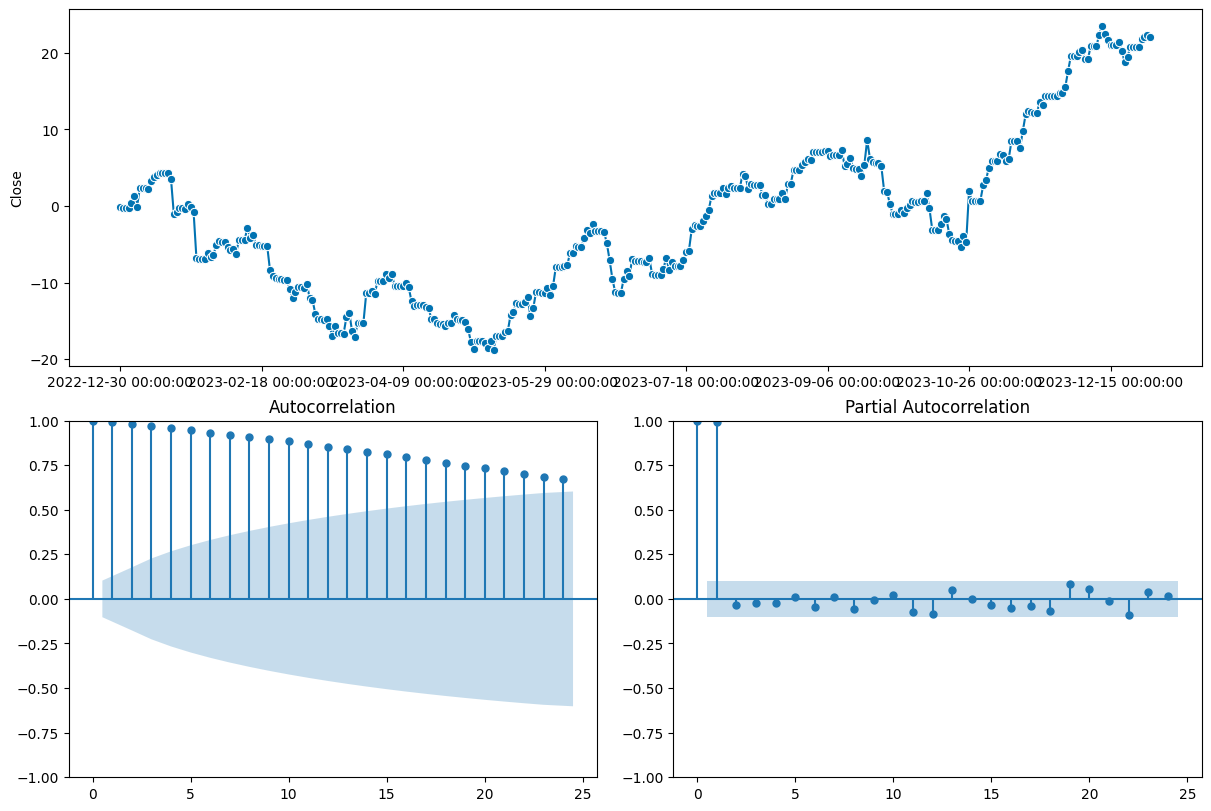

In [59]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()


In [95]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError

cv = ExpandingWindowSplitter(initial_window=3270, step_length = 15, fh=90)

rmse = MeanSquaredError(square_root=True)

#mae
df = evaluate(forecaster=model, y=y_train, cv=cv, scoring=[rmse], strategy="refit", return_data=True)

df.describe()

test_MeanSquaredError   fit_time  pred_time  len_train_window  \
count              58.000000  58.000000  58.000000         58.000000   
mean               16.714053   0.000797   0.001204       3412.500000   
min                 1.704675   0.000638   0.000875       3270.000000   
25%                11.260547   0.000644   0.000912       3341.250000   
50%                16.645330   0.000659   0.000951       3412.500000   
75%                21.635057   0.000831   0.001185       3483.750000   
max                32.442737   0.002559   0.005877       3555.000000   
std                 7.635909   0.000333   0.000781         84.434393   

                    cutoff  
count                   58  
mean   2022-05-06 12:00:00  
min    2021-12-15 00:00:00  
25%    2022-02-24 06:00:00  
50%    2022-05-06 12:00:00  
75%    2022-07-16 18:00:00  
max    2022-09-26 00:00:00  
std                    NaN

  
  Testing with parameters  
    

#### stats tests wip

In [62]:
#from statsmodels.stats.diagnostic import durbin_wu_test

#dw_stat, p_value = durbin_wu_test(residuals)
#print("Durbin-Watson statistic:", dw_stat)


In [63]:
from scipy.stats import jarque_bera

jb_stat, p_value = jarque_bera(residuals)
print("Jarque-Bera statistic:", jb_stat)


Jarque-Bera statistic: 22.135883061689004


In [64]:
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


### Prophet and randomized search

#### --> t(0) Prophet

In [65]:
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon

# Create a new Prophet object
model = Prophet()

# Fit the model to the data
model.fit(y_train)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = model.predict(fh_n)

# scores

functions.plot_and_print_prediction(y_train, y_test, y_pred)

Importing plotly failed. Interactive plots will not work.
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing


129.24845230029453


In [66]:
from sktime.forecasting.model_evaluation import evaluate

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, window_length = 30, fh=90)

#cv = ExpandingWindowSplitter(
#    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72)

df = evaluate(forecaster=model, y=y_train, cv=cv, strategy="refit", return_data=True)

#df.iloc[:, :5]
df.describe()

17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1]

test_MeanAbsolutePercentageError    fit_time   pred_time  \
count                        290.000000  290.000000  290.000000   
mean                           0.069439    0.829558    0.015204   
min                            0.000409    0.437748    0.012250   
25%                            0.039779    0.740185    0.012631   
50%                            0.065528    0.823071    0.013002   
75%                            0.100212    0.901444    0.014167   
max                            0.181535    1.237473    0.179378   
std                            0.042129    0.126778    0.011137   

       len_train_window               cutoff  
count        290.000000                  290  
mean        3414.500000  2022-05-08 12:00:00  
min         3270.000000  2021-12-15 00:00:00  
25%         3342.250000  2022-02-25 06:00:00  
50%         3414.500000  2022-05-08 12:00:00  
75%         3486.750000  2022-07-19 18:00:00  
max         3559.000000  2022-09-30 00:00:00  
std           83.860002                  NaN

In [67]:
# error metrics:
model_name = 'Prophet_param0_t0'
error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0             SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1  SES_gscv_trend0_s00_sp365_t1  47.875986  44.109975  0.321189
2           SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
3  SES_gscv_trend0_s00_sp365_t1  10.521719   8.570503  0.063502
4             Prophet_param0_t0  11.322430   9.442600  0.070145

In [68]:
#storing predictions
model_name = 'Prophet_param0_t0'
predictions_df[model_name] = y_pred.values
predictions_df.head()

y_test  SMA_gscv_win90_t0  SES_gscv_trend0_s00_sp365_t1  \
2022-12-30  134.223755         134.223755                    134.405135   
2022-12-31  134.223755         134.223755                    134.424559   
2023-01-01  134.223755         134.223755                    134.443982   
2023-01-02  134.223755         134.223755                    134.463406   
2023-01-03  134.852524         134.852524                    134.482829   

            SES_gscv_alpha09_t0  Prophet_param0_t0  
2022-12-30           134.223755         129.248452  
2022-12-31           134.223755         129.352980  
2023-01-01           134.223755         129.455893  
2023-01-02           134.223755         129.613099  
2023-01-03           134.852524         129.698743

In [69]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()


#### t(1) Prophet

17:48:44 - cmdstanpy - INFO - Chain [1] start processing
17:48:44 - cmdstanpy - INFO - Chain [1] done processing


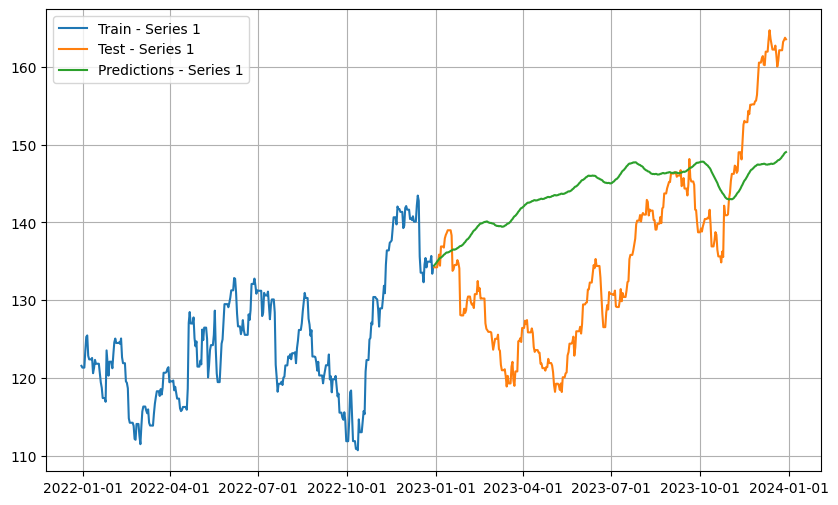

134.45902702951426


In [70]:
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon

# Create a new Prophet object
model = Prophet()

# Fit the model to the data
model.fit(train_transformed)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = model.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

functions.plot_and_print_prediction(y_train, y_test, y_pred)

In [71]:
# error metrics:
model_name = 'Prophet_param0_t1'
error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0             SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1  SES_gscv_trend0_s00_sp365_t1  47.875986  44.109975  0.321189
2           SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
3  SES_gscv_trend0_s00_sp365_t1  10.521719   8.570503  0.063502
4             Prophet_param0_t0  11.322430   9.442600  0.070145
5             Prophet_param0_t1  13.072620  11.132325  0.084950

In [72]:
#storing predictions
predictions_df[model_name] = y_test.values
predictions_df.head()

y_test  SMA_gscv_win90_t0  SES_gscv_trend0_s00_sp365_t1  \
2022-12-30  134.223755         134.223755                    134.405135   
2022-12-31  134.223755         134.223755                    134.424559   
2023-01-01  134.223755         134.223755                    134.443982   
2023-01-02  134.223755         134.223755                    134.463406   
2023-01-03  134.852524         134.852524                    134.482829   

            SES_gscv_alpha09_t0  Prophet_param0_t0  Prophet_param0_t1  
2022-12-30           134.223755         129.248452         134.223755  
2022-12-31           134.223755         129.352980         134.223755  
2023-01-01           134.223755         129.455893         134.223755  
2023-01-02           134.223755         129.613099         134.223755  
2023-01-03           134.852524         129.698743         134.852524

In [73]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()

### ARIMA

In [74]:
from sktime.forecasting.arima import ARIMA

#### --> t(0) ARIMA

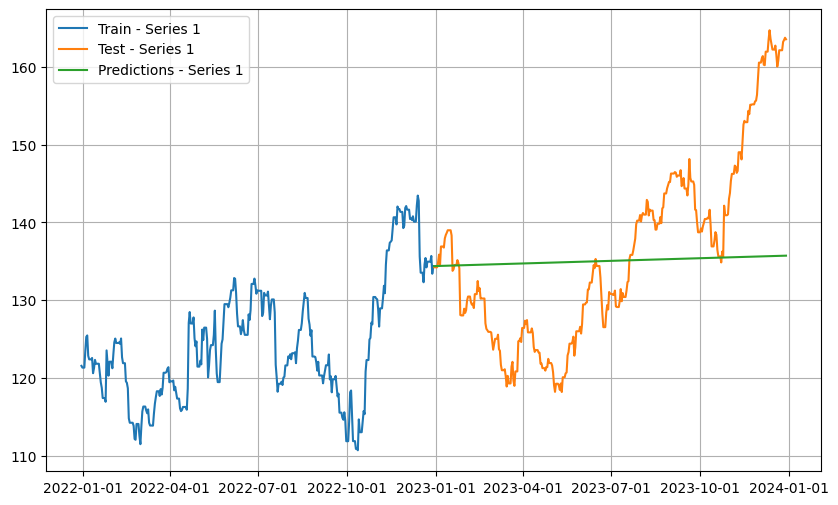

134.37825774469712


In [75]:
model = ARIMA(order=(1, 1, 0))
# parameters:
# p = 1 due to lag 1
# d = 1 due to input data not yet differenced
# q test 0 or 1

# Fit the model to the data
model.fit(y_train)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = model.predict(fh_n)

functions.plot_and_print_prediction(y_train, y_test, y_pred)

In [76]:
# error metrics:
model_name = 'ARIMA_1_1_0_t(0)'
error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0             SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1  SES_gscv_trend0_s00_sp365_t1  47.875986  44.109975  0.321189
2           SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
3  SES_gscv_trend0_s00_sp365_t1  10.521719   8.570503  0.063502
4             Prophet_param0_t0  11.322430   9.442600  0.070145
5             Prophet_param0_t1  13.072620  11.132325  0.084950
6              ARIMA_1_1_0_t(0)  11.625930   9.349065  0.067615

In [77]:
#storing predictions
model_name = 'ARIMA_1_1_0_t(0)'
predictions_df[model_name] = y_pred.values
predictions_df.head()

y_test  SMA_gscv_win90_t0  SES_gscv_trend0_s00_sp365_t1  \
2022-12-30  134.223755         134.223755                    134.405135   
2022-12-31  134.223755         134.223755                    134.424559   
2023-01-01  134.223755         134.223755                    134.443982   
2023-01-02  134.223755         134.223755                    134.463406   
2023-01-03  134.852524         134.852524                    134.482829   

            SES_gscv_alpha09_t0  Prophet_param0_t0  Prophet_param0_t1  \
2022-12-30           134.223755         129.248452         134.223755   
2022-12-31           134.223755         129.352980         134.223755   
2023-01-01           134.223755         129.455893         134.223755   
2023-01-02           134.223755         129.613099         134.223755   
2023-01-03           134.852524         129.698743         134.852524   

            ARIMA_1_1_0_t(0)  
2022-12-30        134.378258  
2022-12-31        134.382067  
2023-01-01        134.385748  
2023-01-02        134.389431  
2023-01-03        134.393114

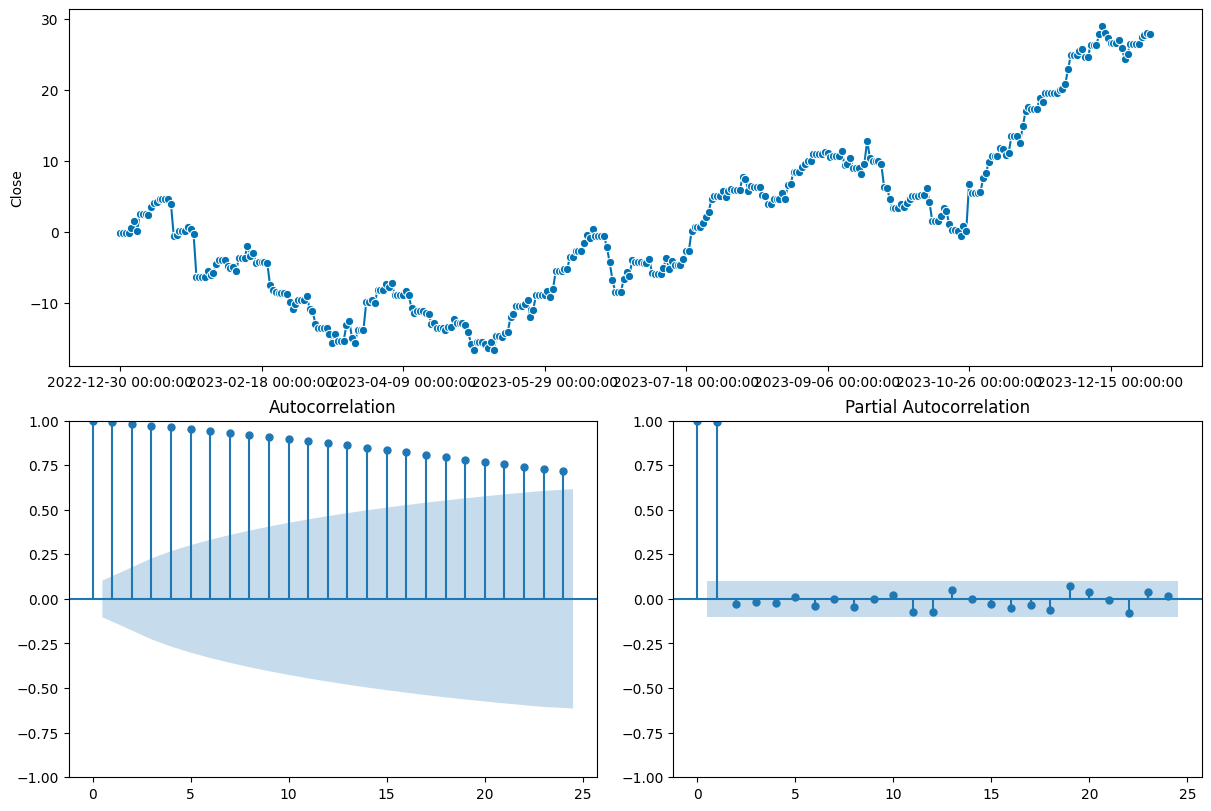

In [78]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()

In [96]:
from sktime.forecasting.model_evaluation import evaluate

cv = ExpandingWindowSplitter(initial_window=3270, step_length = 15, fh=90)

df = evaluate(forecaster=model, y=y_train, cv=cv, strategy="refit", return_data=True)

#df.iloc[:, :5]
df.describe()

test_MeanAbsolutePercentageError   fit_time  pred_time  \
count                         20.000000  20.000000  20.000000   
mean                           0.128055   0.000942   0.001282   
min                            0.015371   0.000644   0.000911   
25%                            0.101316   0.000651   0.000941   
50%                            0.130405   0.000784   0.001127   
75%                            0.164806   0.001016   0.001489   
max                            0.226076   0.002846   0.002528   
std                            0.055717   0.000495   0.000431   

       len_train_window               cutoff  
count         20.000000                   20  
mean        3412.500000  2022-05-06 12:00:00  
min         3270.000000  2021-12-15 00:00:00  
25%         3341.250000  2022-02-24 06:00:00  
50%         3412.500000  2022-05-06 12:00:00  
75%         3483.750000  2022-07-16 18:00:00  
max         3555.000000  2022-09-26 00:00:00  
std           88.741197                  NaN

In [80]:
import seaborn as sns
plt.show()

sns.histplot(data=df, x='test_MeanAbsolutePercentageError')

<Axes: xlabel='test_MeanAbsolutePercentageError', ylabel='Count'>

In [81]:
sns.boxplot(data=df, x='test_MeanAbsolutePercentageError')

plt.show()

#### t(1) ARIMA

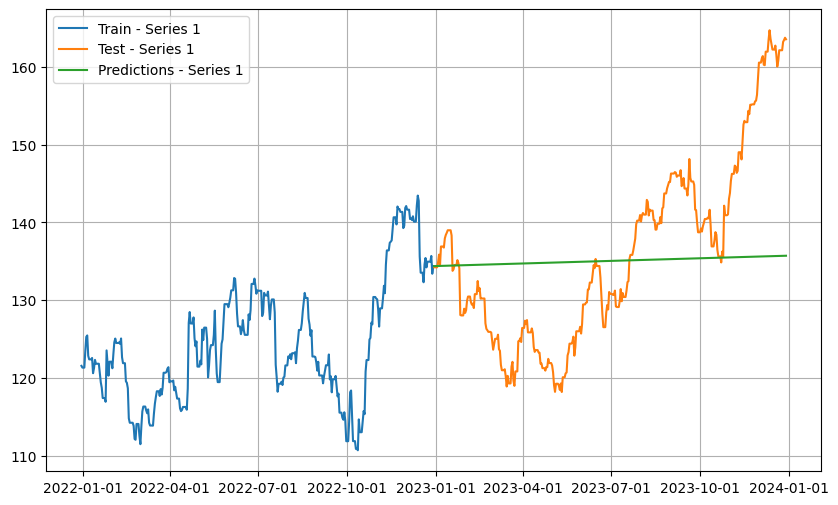

134.37823125421698


In [82]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon

# 1,0,0
# 1,1,0
# 1,1,1
# Create a new Prophet object
model = ARIMA(order=(1, 0, 0))

# Fit the model to the data
model.fit(train_transformed)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = model.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

functions.plot_and_print_prediction(y_train, y_test, y_pred)


In [83]:
# saving error metrics:
model_name = 'ARIMA_1_0_0_t(1)'
error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0             SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1  SES_gscv_trend0_s00_sp365_t1  47.875986  44.109975  0.321189
2           SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
3  SES_gscv_trend0_s00_sp365_t1  10.521719   8.570503  0.063502
4             Prophet_param0_t0  11.322430   9.442600  0.070145
5             Prophet_param0_t1  13.072620  11.132325  0.084950
6              ARIMA_1_1_0_t(0)  11.625930   9.349065  0.067615
7              ARIMA_1_0_0_t(1)  11.628446   9.350919  0.067626

In [84]:
#storing predictions
predictions_df[model_name] = y_test.values
predictions_df.head()

y_test  SMA_gscv_win90_t0  SES_gscv_trend0_s00_sp365_t1  \
2022-12-30  134.223755         134.223755                    134.405135   
2022-12-31  134.223755         134.223755                    134.424559   
2023-01-01  134.223755         134.223755                    134.443982   
2023-01-02  134.223755         134.223755                    134.463406   
2023-01-03  134.852524         134.852524                    134.482829   

            SES_gscv_alpha09_t0  Prophet_param0_t0  Prophet_param0_t1  \
2022-12-30           134.223755         129.248452         134.223755   
2022-12-31           134.223755         129.352980         134.223755   
2023-01-01           134.223755         129.455893         134.223755   
2023-01-02           134.223755         129.613099         134.223755   
2023-01-03           134.852524         129.698743         134.852524   

            ARIMA_1_1_0_t(0)  ARIMA_1_0_0_t(1)  
2022-12-30        134.378258        134.223755  
2022-12-31        134.382067        134.223755  
2023-01-01        134.385748        134.223755  
2023-01-02        134.389431        134.223755  
2023-01-03        134.393114        134.852524

In [85]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()

#### t(0) autoARIMA

In [86]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from matplotlib import pyplot

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

# create model
model_autoarima = AutoARIMA(start_p=1, max_p=10, sp=1, seasonal=False, suppress_warnings=True)

# fit model
model_autoarima.fit(y_train)
y_pred = model_autoarima.predict(fh_n)

# scores
model_name = 'autoARIMA_p1_10_sp1_t(0)'

error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result


Model      RMSE       MAE      MAPE
0  autoARIMA_p1_10_sp1_t(0)  12.00191  9.616052  0.069206

In [87]:
# saving error metrics:
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0             SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1  SES_gscv_trend0_s00_sp365_t1  47.875986  44.109975  0.321189
2           SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
3  SES_gscv_trend0_s00_sp365_t1  10.521719   8.570503  0.063502
4             Prophet_param0_t0  11.322430   9.442600  0.070145
5             Prophet_param0_t1  13.072620  11.132325  0.084950
6              ARIMA_1_1_0_t(0)  11.625930   9.349065  0.067615
7              ARIMA_1_0_0_t(1)  11.628446   9.350919  0.067626
8      autoARIMA_p1_10_sp1_t(0)  12.001910   9.616052  0.069206

In [88]:
# summary of fit model
print(model_autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3649
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6134.900
Date:                Fri, 02 Feb 2024   AIC                          12271.800
Time:                        17:49:07   BIC                          12278.002
Sample:                    01-02-2013   HQIC                         12274.009
                         - 12-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.6914      0.014    120.797      0.000       1.664       1.719
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):             30451.09
Prob(Q):                              0.50   Pr

#### t(1) autoARIMA

In [ ]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from matplotlib import pyplot

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

# create model
model_autoarima = AutoARIMA(start_p=1, max_p=10, sp=1, seasonal=False, suppress_warnings=True)

# fit model
model_autoarima.fit(train_transformed)
y_pred_transformed = model.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

# scores
model_name = 'autoARIMA_p1_10_sp1_t(1)'

error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

In [ ]:
model_autoarima.summary()

In [ ]:
model_autoarima.get_fitted_params()

In [ ]:
# saving error metrics:
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

### --> Combi-Model

In [ ]:
# store model predictions SES_gscv_trend0_s00_sp365_t1	Prophet_param0_t0	ARIMA_1_1_0_t(0)
#predictions_df.head()
model1_pred = predictions_df['Prophet_param0_t0'] #prophet (5)
model2_pred = predictions_df['SES_gscv_trend0_s00_sp365_t1']  #SES (4)
model3_pred = predictions_df['ARIMA_1_1_0_t(0)']  #SES (4) too similar to SES, not sued

# estimation of the weights for each model based on inverse proportional RMSE scores
RMSE_model1 = 11.321214 #prophet (5)
RMSE_model2 = 11.626932 # SES (4)

w10 = 1/RMSE_model1
w20 = 1/RMSE_model2
#w30 = 1/RMSE_model3
w1 = w10/(w10 + w20)
w2 = w20/(w10 + w20)
print(w1+w2)

In [ ]:
# create model
#combined_model = (w1 * model1.predict()) + (w2 * model2.predict()) + (w3 * model3.predit())
combined_model = (w1 * model1_pred) + (w2 * model2_pred)
combined_model

In [ ]:
predictions_df['combined_model'] = combined_model.values
predictions_df.head()


In [ ]:
from sklearn.metrics import root_mean_squared_error
RMSE_combi_model = root_mean_squared_error(y_test, combined_model)
print(RMSE_combi_model)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE_combi_model = mean_absolute_percentage_error(y_test, combined_model)
print(MAPE_combi_model)

In [ ]:
model1_pred
model2_pred
combined_model

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the colormap
cmap = cm.get_cmap('coolwarm')

plt.figure(figsize=(10, 6))
# Plot each series
plt.plot(y_train.iloc[-365*4: ], label='y_train', color = cmap(0.2))
plt.plot(y_test, label='y_true', color = cmap(0.3))
plt.plot(model2_pred, label='SES Prediction', color = cmap(0.6))
plt.plot(model1_pred, label='Prophet Prediction', color = cmap(0.7))
plt.plot(combined_model, label='Combined Model Prediction', color = cmap(0.8))

# Set title and labels
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Prediction Value')

# Add legend
plt.legend()

# Display plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the colormap
cmap = cm.get_cmap('coolwarm')

plt.figure(figsize=(10, 6))
# Plot each series
#plt.plot(y_train.iloc[-365*1: ], label='y_train', color = cmap(0.2))
plt.plot(y_test, label='y_true', color = cmap(0.3))
plt.plot(model2_pred, label='SES Prediction', color = cmap(0.6))
plt.plot(model1_pred, label='Prophet Prediction', color = cmap(0.7))
plt.plot(combined_model, label='Combined Model Prediction', color = cmap(0.8))

# Set title and labels
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Prediction Value')

# Add legend
plt.legend()

# Display plot
plt.show()


## Models building part ii: Reduction: from forecasting to regression

### GradientBoost

#### t(0)

In [ ]:
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train)
#RecursiveTabularRegressionForecaster(...)
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = forecaster.predict(fh_n)

# scores
model_name = 'reg_gradientboostin_param0_t(0)'

error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

#### t(1)

In [ ]:
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

forecaster.fit(train_transformed)

#RecursiveTabularRegressionForecaster(...)
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = forecaster.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)
# scores
model_name = 'reg_gradientboostin_param0_t(1)'
error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

### KNeighborsRegressor

#### t(0)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series

regressor = KNeighborsRegressor(n_neighbors=4)
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh_n)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
#mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

# scores
model_name = 'reg_knn_n1_t(0)'
error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

In [ ]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()


#### t(1)

#### For Loop: KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

model_scoring_KNN = pd.DataFrame()
model_scoring_KNN_CV = pd.DataFrame()
model_scoring_KNN_CV_dict = {}

for i in [1,4,5,9]:
    for w in [1,2, 3,4, 10, 45]:
        model_name = f' KNN params: win_lengh = {w}; n= {i}'
        print(model_name)
        regressor = KNeighborsRegressor(n_neighbors=i)
        forecaster = make_reduction(regressor, window_length=w, strategy="recursive")
        fh_n = ForecastingHorizon(y_test.index, is_relative=False)   
        forecaster.fit(train_transformed) 
        y_pred_transformed = forecaster.predict(fh_n)
        y_pred = differencer.inverse_transform(y_pred_transformed)  
         # scores
        error_metrics_result = functions.calculate_error_metrics(model_name, y_test, y_pred)
        model_scoring_KNN = pd.concat([model_scoring_KNN, error_metrics_result], ignore_index=True)
        print(error_metrics_result)   
        
        #plot
        plot_series(y_train.iloc[365*2:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
        plt.show()   
        
        # eval
        cv = ExpandingWindowSplitter(initial_window=3270, step_length=15, fh=90)
        rmse = MeanSquaredError(square_root=True)
        model_name_scoring = f'win_lengh = {w}; n= {i}'
        model_scoring_KNN_CV_dict[model_name_scoring] = evaluate(forecaster=forecaster, y=y_train, cv=cv, scoring=[rmse], strategy="refit", return_data=True)
        
        #residuals
        residuals = y_test - y_pred
        import matplotlib.pyplot as plt
        from sktime.utils.plotting import plot_correlations
        fig, ax = plot_correlations(residuals)
        plt.show()

display(model_scoring_KNN)



In [ ]:
model_scoring_KNN_sorted = model_scoring_KNN.sort_values(by='RMSE').reset_index()
model_scoring_KNN_sorted

In [ ]:
knn_model_name_list = ['win_lengh = 3; n= 9',
'win_lengh = 10; n= 5',
'win_lengh = 45; n= 4',
'win_lengh = 4; n= 1']
knn_model_name_list
for model in knn_model_name_list:
    print(model)
    display(model_scoring_KNN_CV_dict[model].describe())

In [ ]:
model_scoring_KNN_CV_dict

In [ ]:
for i in [1,4,5,9]:
    print(f' KNN n= {i}')
    display(model_scoring_KNN_CV_dict[i].describe())